In [8]:
import json
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import ast
import math
import os
import sys
import re
import pickle

import plotly
from plotly.subplots import make_subplots
from datasets import Dataset, load_from_disk

import torch
from torch import nn

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from performanceUtils import *
from tokenizationUtils import tokenize_batch

## Set-up

In [411]:
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid", {'font.family': "arial", "font.size": 10})

color_palette = sns.color_palette()
pastel_palette = sns.color_palette('pastel')
blues_palette = sns.color_palette('Blues')

### Loading datasets

In [3]:
def binarized(x, n_classes):
    idx = list(x.values)
    binarized = np.zeros(n_classes)
    binarized[idx] = 1
    return binarized


def load_data(directory_path:str, file_path:str, feature_col:str=None, target_col:str=None,
    top_classes=None, multilabel=False):
    top_classes = None
    assert((feature_col is not None) and (target_col is not None)), \
        'Please specify both feature and target columns on the config.json file.'
    # Loading data
    dataset_df = load_csv_dataset(directory_path + file_path, feature_col, target_col)
    # Preprocessing datasets
    if 'transcriptions' in file_path: 
        # Proposed labels
        labels_norename = [
            'Autopsy', 'Bariatrics', 'Dentistry', 'Dermatology', 'Diets and Nutritions', 
            'Endocrinology', 'Gastroenterology', 'Nephrology', 'Neurology', 'Ophthalmology', 
            'Radiology', 'Sleep Medicine', 'Urology', 'Orthopedic', 'Neurosurgery', 'Podiatry', 
            'Rheumatology', 'Surgery'
        ]
        labels_rename = {
            'Allergy / Immunology': 'Allergy or Immunology',
            'Cardiovascular / Pulmonary': 'Cardiovascular or Pulmonary',
            'Chiropractic': 'Physical Medicine and Rehabilitation, or Chiropractic',
            'Cosmetic / Plastic Surgery': 'Cosmetic or Plastic Surgery',
            'ENT - Otolaryngology': 'Otolaryngology',
            'Hematology - Oncology': 'Hematology or Oncology',
            'Lab Medicine - Pathology': 'Laboratory Medicine or Clinical Pathology',
            'Obstetrics / Gynecology': 'Obstetrics or Gynecology',
            'Pediatrics - Neonatal': 'Pediatrics or Neonatal',
            'Physical Medicine - Rehab': 'Physical Medicine and Rehabilitation, or Chiropractic',
            'Psychiatry / Psychology': 'Psychiatry or Psychology',
            'Speech - Language': 'Speech and Language'
        }
        # Preprocessing targets: masking and renaming
        dataset_df = dataset_df.loc[dataset_df['target'].isin(labels_norename + list(labels_rename.keys()))]
        dataset_df.loc[:, 'target'] = dataset_df.loc[:, 'target'].replace(labels_rename).values.tolist()
        # Preporcessing features: cleaning
        dataset_df.loc[:, 'feature'] = dataset_df.loc[:, 'feature'].str.replace(' +', ' ', regex=True)\
            .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
            .str.replace(':\s*,\s*', ':\n', regex=True)\
            .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()
    # Restricting to top classes
    if not(top_classes is None):
        top_values = dataset_df['target'].value_counts().sort_values(ascending=False)\
            .head(top_classes).index.sort_values().tolist()
        dataset_df.loc[~dataset_df['target'].isin(top_values), 'target'] = 'Other'
    # Defining labels
    dataset_df['target'] = dataset_df['target'].astype('category')
    if not(top_classes is None): 
        dataset_df['target'] = dataset_df['target'].cat.reorder_categories(top_values + ['Other'])
    labels = dataset_df['target'].cat.categories.tolist()
    dataset_df['target'] = dataset_df['target'].cat.codes
    if multilabel:
        n_classes = len(labels)
        temp = dataset_df.groupby('feature').target.apply(lambda x: binarized(x, n_classes)).reset_index()
        dataset_df = dataset_df[['feature']].merge(temp, on='feature', how='left')
    # Converting into dataset
    dataset = Dataset.from_pandas(dataset_df, preserve_index=False)

    return dataset, labels


def load_csv_dataset(file_path:str, feature_col:str, target_col:str):
    # Loading dataset, renaming columns, and dropping NAs
    df = pd.read_csv(file_path, usecols=[feature_col, target_col])
    df.rename(columns={feature_col: 'feature', target_col: 'target'}, inplace=True)
    df.dropna(inplace=True)

    # Cleaning target column
    df['target'] = df['target'].str.strip()

    return df

In [4]:
with open('../config.json') as f:
        configuration = json.load(f)
data_path = configuration['data']['path']

data = {}
for dataset_name in ['ms-cxr', 'transcriptions']:
    dataset, labels = load_data(data_path, **configuration[dataset_name])
    data[dataset_name] = {
        'data': pd.DataFrame(dataset),
        'labels': labels
    }

### Functions

In [177]:
def cosine_similarity(x: torch.Tensor, y: torch.Tensor):
    distance = nn.functional.normalize(x) @ nn.functional.normalize(y).t()
    return distance.cpu().numpy()


def softmax(logits, dim=1):
    return nn.functional.softmax(logits, dim=dim)


def create_perclass_df(df, base_cols, metrics, n_classes):
    df_new = []
    for metric in metrics:
        try:
            df.loc[:, metric] = df.loc[:, metric].apply(lambda x: ast.literal_eval(x) if type(x)==str else x)
        except:
            df.loc[:, metric] = df.loc[:, metric].str.replace('\n', '').str.replace('\s+', ',', regex=True)\
                .apply(lambda x: ast.literal_eval(x))
        df_new.append(df[base_cols + [metric]].explode(metric))

    df_new = pd.concat(df_new, axis=1)
    df_new = df_new.loc[:, ~df_new.columns.duplicated()]
    df_new['class'] = np.tile([str(i) for i in range(n_classes)], df_new.shape[0]//n_classes)
    df_new.merge(df[['model', 'modelID']], on='model', how='left')

    return df_new


def text2label(context:list, labels:list, mca:str):
    replace = dict(zip(eval(mca)[:len(labels)], range(len(labels))))
    return list(map(lambda x: replace[x.split('(')[-1]] if x.split('(')[-1] in replace.keys() else -1, context))

## Encoder-like models
**Task:** Classification

**Datasets:** Transcriptions and MS-CXR

### Set-up

**Functions**

In [6]:
def explore_results(data, metrics):
    general = []
    for metric in metrics:
        idx_max = data[metric].where(data[metric] == data[metric].max()).dropna().index
        idx_min = data[metric].where(data[metric] == data[metric].min()).dropna().index
        general.append(dict(
            metric=metric,
            best_model=(data.loc[idx_max, 'model'] + '|' + data.loc[idx_max, 'pool'] + '|' + data.loc[
                idx_max, 'template'] + '|' +  data.loc[idx_max, 'overflow'].astype(str)).values.tolist(),
            best_value=data[metric].loc[idx_max[0]],
            worst_model=(data.loc[idx_min, 'model'] + '|' + data.loc[idx_min, 'pool'] + '|' + data.loc[
                idx_min, 'template'] + '|' + data.loc[idx_min, 'overflow'].astype(str)).values.tolist(),
            worst_value=data[metric].loc[idx_min[0]],
        ))

    return pd.DataFrame(general)


def aggregate_update_embedding(pool, ds_original, ds_embedding, col_name):
    if ds_embedding.num_rows != ds_original.num_rows:
        df = ds_embedding.to_pandas()[['attention_mask', 'overflow_to_sample_mapping', col_name]]\
            .groupby('overflow_to_sample_mapping')
        if pool == 'CLS_pool':
            embedding = df[col_name].agg(lambda x: np.vstack(x).mean(axis=0)).values.tolist()
        elif pool == 'max_pool':
            embedding = df[col_name].agg(lambda x: np.vstack(x).max(axis=0)).values.tolist()
        else:
            embedding = df.apply(lambda x: np.average(np.vstack(x[col_name]), axis=0, 
                weights=np.vstack(x['attention_mask']).sum(axis=1))).values.tolist()
    else: 
        embedding = ds_embedding[col_name]
    ds_original = ds_original.add_column(col_name, embedding)

    return ds_original

**Results**

In [79]:
from tqdm import tqdm

# Option 1
def load_pickle(path:str):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

aux = [['', '0', '1', '5', '6', '7'], ['', '0', '1', '2', '3', '4']]
m_list = ["bert-base-uncased", "bert-large-uncased", "BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "BiomedNLP-PubMedBERT-base-uncased-abstract", "BiomedNLP-PubMedBERT-large-uncased-abstract",
    "SapBERT-from-PubMedBERT-fulltext", "Bio_ClinicalBERT", "BioLORD-STAMB2-v1", "BioLORD-STAMB2-v1-STS2",
    "BioLORD-PMB", "scibert_scivocab_uncased"]
col_e = ['sentence_embedding', 'embedding']
excs = [[395, 407, 97], [[2,3], [2,3], [4,6]]]

results_encoder = []
for i, d in enumerate(['ms-cxr', 'transcriptions']):
    m_l = d == 'transcriptions'
    keep_idx = data[d]['data'][~data[d]['data']['feature'].duplicated()].index
    target = np.vstack(data[d]['data'].loc[keep_idx, 'target'].apply(lambda x: np.array(x)).values) \
        if d == 'transcriptions' else data['ms-cxr']['data'].loc[keep_idx, 'target'].values
    for m in tqdm(m_list):
        for s in ['', '_o']:
            for p in ['CLS', 'max', 'avg']:
                file_path = f'../../results/temp/encode_{d}_{m}_{p}_pool'
                try:
                    d_ = load_from_disk(file_path + s)
                except:
                    continue
                if s == '_o':
                    d_ = aggregate_update_embedding(p, Dataset.from_pandas(data[d]['data'], 
                        preserve_index=False), d_, 'embedding').select(keep_idx)
                else:
                    d_ = d_.select(keep_idx)
                for t in aux[i]:
                    t_ = load_pickle(file_path + f'_{t}.pkl')
                    scores = cosine_similarity(torch.tensor(d_[col_e[i]]), torch.tensor(t_['embedding']))
                    results_encoder.append([f'{m}_{p}_pool_{t}_{s[-1:]}', d] + 
                        measure_classification(target, scores, multilabel=m_l, 
                        exceptions=excs if d == 'ms-cxr' else None))

results_encoder = pd.DataFrame(results_encoder, columns=['model', 'data', 'accuracy', 
    'balanced_accuracy', 'accuracy_top3', 'accuracy_top5', 'auc', 'c_auc', 'f1', 'precision', 
    'recall', 'c_f1', 'c_precision', 'c_recall'])

# Option 2
#results_encoder = pd.read_csv('../../results/results_encoder.csv', sep='|')

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [09:08<00:00, 49.90s/it]


In [80]:
results_encoder.head()

,model,data,accuracy,balanced_accuracy,accuracy_top3,accuracy_top5,auc,c_auc,f1,precision,recall,c_f1,c_precision,c_recall
0,bert-base-uncased_CLS_pool__,ms-cxr,0.200000,0.221308,0.391608,0.658741,NaN,None,0.179980,0.434036,0.221308,"[0.24324324324324326, 0.09302325581395349, 0.1...","[0.5, 0.3333333333333333, 0.2692307692307692, ...","[0.16071428571428573, 0.05405405405405406, 0.0..."
1,bert-base-uncased_CLS_pool_0_,ms-cxr,0.222378,0.247937,0.490909,0.626573,NaN,None,0.201179,0.494752,0.247937,"[0.3055555555555555, 0.4255319148936171, 0.0, ...","[0.6875, 1.0, 0.0, 0.0, 0.1509433962264151, 0....","[0.19642857142857142, 0.2702702702702703, 0.0,..."
2,bert-base-uncased_CLS_pool_1_,ms-cxr,0.211189,0.225982,0.511888,0.678322,NaN,None,0.163814,0.534950,0.225982,"[0.12903225806451613, 0.15, 0.1290322580645161...","[0.6666666666666666, 1.0, 0.36363636363636365,...","[0.07142857142857142, 0.08108108108108109, 0.0..."
3,bert-base-uncased_CLS_pool_5_,ms-cxr,0.377622,0.389875,0.633566,0.770629,NaN,None,0.358696,0.500589,0.389875,"[0.26829268292682923, 0.5846153846153848, 0.28...","[0.4230769230769231, 0.6785714285714286, 0.423...","[0.19642857142857142, 0.5135135135135135, 0.21..."
4,bert-base-uncased_CLS_pool_6_,ms-cxr,0.212587,0.274222,0.528671,0.681119,NaN,None,0.199359,0.430594,0.274222,"[0.18181818181818182, 0.4109589041095891, 0.10...","[0.1267605633802817, 0.4166666666666667, 0.461...","[0.32142857142857145, 0.40540540540540543, 0.0..."


In [81]:
results_encoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              594 non-null    object 
 1   data               594 non-null    object 
 2   accuracy           198 non-null    float64
 3   balanced_accuracy  198 non-null    float64
 4   accuracy_top3      198 non-null    float64
 5   accuracy_top5      198 non-null    float64
 6   auc                396 non-null    float64
 7   c_auc              396 non-null    object 
 8   f1                 198 non-null    float64
 9   precision          198 non-null    float64
 10  recall             198 non-null    float64
 11  c_f1               198 non-null    object 
 12  c_precision        198 non-null    object 
 13  c_recall           198 non-null    object 
dtypes: float64(8), object(6)
memory usage: 65.1+ KB


In [82]:
col_order = ['model', 'modelID', 'pool', 'template', 'overflow'] + results_encoder.columns.to_list()[1:]
results_encoder[['model', 'pool', 'template', 'overflow']] = list(results_encoder.model.str.split('_')\
    .apply(lambda x: ('_'.join(x[:-4]), x[-4], x[-2], x[-1])))
models = results_encoder['model'].drop_duplicates().values.tolist()

In [83]:
results_encoder['modelID'] = results_encoder['model'].replace({
    'bert-base-uncased': 0, 
    'bert-large-uncased': 1,
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 2,
    'BiomedNLP-PubMedBERT-base-uncased-abstract': 3,
    'BiomedNLP-PubMedBERT-large-uncased-abstract': 4,
    'scibert_scivocab_uncased': 5,
    'SapBERT-from-PubMedBERT-fulltext': 6,
    'BioLORD-STAMB2-v1': 7, 
    'BioLORD-STAMB2-v1-STS2': 8, 
    'BioLORD-PMB': 9,
    'Bio_ClinicalBERT': 10
    }
)
results_encoder = results_encoder.sort_values(by=['data', 'overflow', 'modelID', 'pool'])
results_encoder = results_encoder[col_order]
results_encoder['modelID'] = 'm' + results_encoder['modelID'].astype(str)

In [84]:
results_encoder.to_csv('../../results/results_encoder.csv', sep='|', index=False)

### A. MS-CXR
#### A.1. General analysis

In [63]:
dataset_name = 'ms-cxr'

general_metrics = ['accuracy', 'f1', 'precision', 'recall']
individual_metrics = ['c_f1', 'c_precision', 'c_recall']

In [64]:
df_results = results_encoder[results_encoder['data'] == dataset_name].copy()
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results, general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,accuracy,[BioLORD-STAMB2-v1-STS2|avg|5|],0.696503,[bert-large-uncased|CLS|0|],0.078322
1,f1,[BioLORD-STAMB2-v1-STS2|avg||],0.693394,[bert-large-uncased|CLS|0|],0.053566
2,precision,[BioLORD-PMB|CLS||],0.833403,[bert-large-uncased|CLS|7|],0.100324
3,recall,[BioLORD-STAMB2-v1-STS2|avg||],0.725825,[bert-large-uncased|CLS|0|],0.115809


General with template

In [65]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'pool', 'template', 'overflow', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'pool', 'template', 'overflow', 'data'], var_name='metric')
df_results_long['template_use'] = df_results_long['template'] == ''

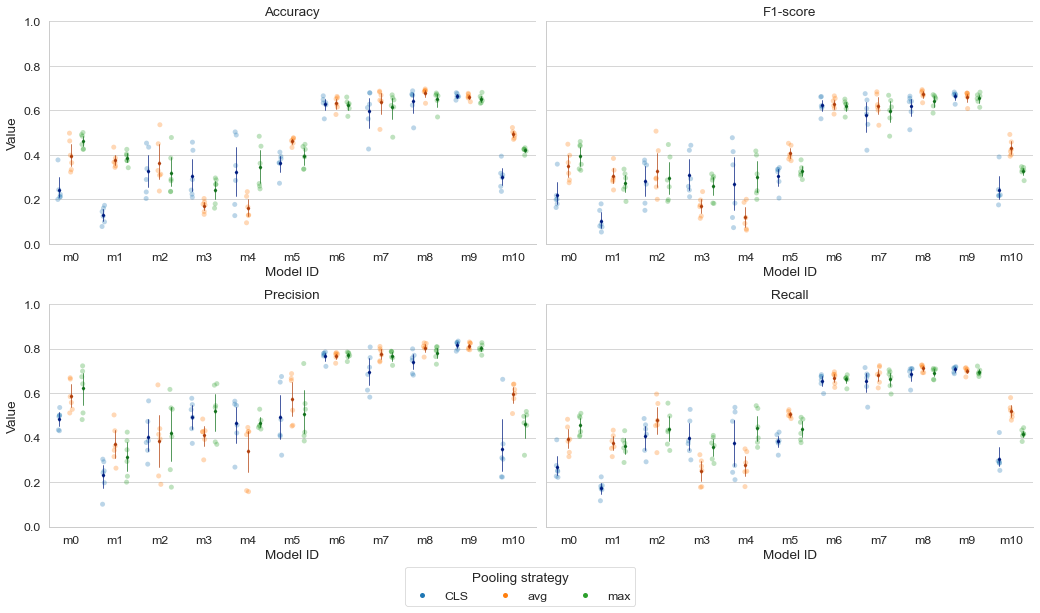

In [30]:
titles = ['Accuracy', 'F1-score', 'Precision', 'Recall']

g = sns.catplot(df_results_long, x='modelID', y='value', hue='pool', col='metric', col_wrap=2, dodge=True,
    alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, height=4, 
    aspect= 1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.07), ncol=4, title='Pooling strategy', frameon=True)
plt.savefig('../../results/plots/ms-cxr_encoder_general.png', bbox_inches='tight', dpi=600)

General without template

In [31]:
explore_results(df_results[df_results['template'] == ''], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,accuracy,[BioLORD-STAMB2-v1-STS2|avg||],0.690909,[BiomedNLP-PubMedBERT-large-uncased-abstract|a...,0.095105
1,f1,[BioLORD-STAMB2-v1-STS2|avg||],0.693394,[BiomedNLP-PubMedBERT-large-uncased-abstract|C...,0.073403
2,precision,[BioLORD-PMB|CLS||],0.833403,[bert-large-uncased|CLS||],0.196746
3,recall,[BioLORD-STAMB2-v1-STS2|avg||],0.725825,[BiomedNLP-PubMedBERT-large-uncased-abstract|a...,0.179385


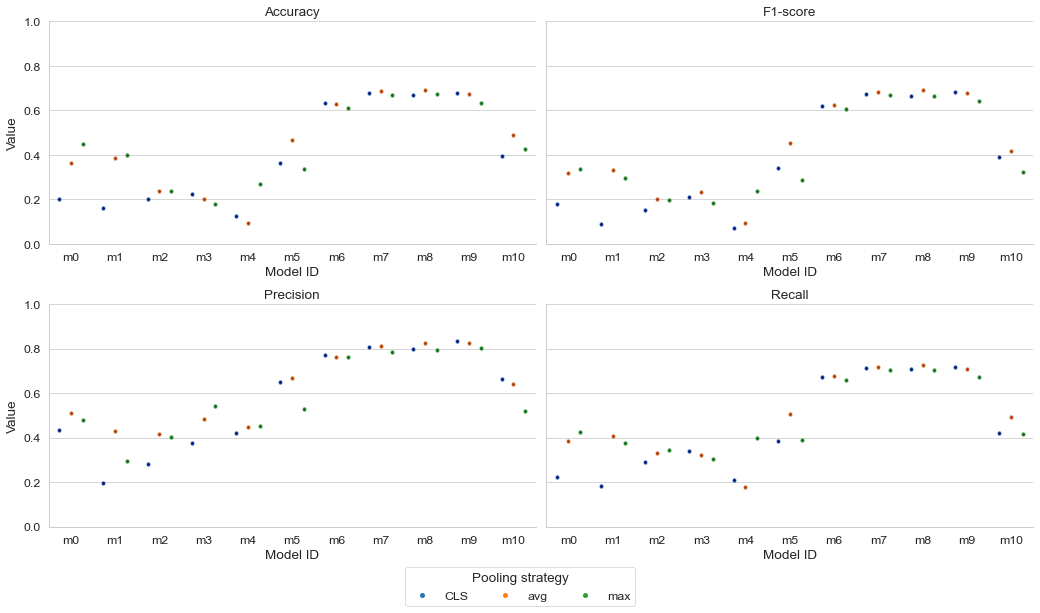

In [32]:
titles = ['Accuracy', 'F1-score', 'Precision', 'Recall']

g = sns.catplot(df_results_long[df_results_long['template'] == ''], x='modelID', y='value', 
    hue='pool', col='metric', col_wrap=2, dodge=True, alpha=.3, legend=True, zorder=1, kind='strip', 
    sharex=False, margin_titles=False, height=4, aspect=1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.07), ncol=4, title='Pooling strategy', frameon=True)
plt.savefig('../../results/plots/ms-cxr_encoder_general_.png', bbox_inches='tight', dpi=600)

Detailed by template

In [67]:
titles = ['Template ' + (x if x != '' else 'none') for x in df_results['template'].drop_duplicates().values]
categories = df_results['modelID'].drop_duplicates().values.tolist()

fig = make_subplots(rows=2, cols=3, specs=[[{'type': 'polar'}] * 3] * 2, horizontal_spacing=0.1,
  vertical_spacing=0.1, subplot_titles=titles)

for i, template in enumerate(df_results['template'].drop_duplicates().values):
  for j, pool in enumerate(df_results['pool'].drop_duplicates().values):
    fig.add_trace(
      go.Scatterpolar(
        r=df_results.loc[(df_results['pool'] == pool) & (df_results['template'] == template), 'f1'],
        theta=categories,
        name=pool,
        line=dict(color='rgb'+str(color_palette[j]), width=1),
        legendgroup=pool,
        showlegend=((i//3)+(i%3)==0)
      ),
      row=(i//3)+1, col=(i%3)+1
    )

fig.update_polars(
  radialaxis=dict(
    visible=True, range=[0, 1], tickfont = dict(size = 10)
  ),
  angularaxis=dict(
    tickangle=0, tickfont = dict(size = 10)
  )),

fig.update_layout(
  autosize=False, width=900, height=700,
  #title="AUC-score by template, model, and pooling strategy",
  #template='whi'
  legend=dict(
    title_text='Pooling strategy', orientation="h", yanchor="bottom", y=-0.1, xanchor="right", x=1
  ),
  margin=dict(l=30, r=30, t=30, b=0)
)
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.show()
fig.write_image('../../results/plots/ms-cxr_encoder_detail.png', scale=2)

In [50]:
r1 = df_results_long.fillna('').groupby(['model', 'template', 'metric', 'pool'])['value'].max().reset_index()
r2 = r1.merge(r1[r1['template'] == ''], on=['model', 'metric', 'pool'])
r2['diff'] = r2['value_x'] - r2['value_y']
r3 = r2.groupby(['model', 'metric', 'pool'])['diff'].agg(['min', 'max']).reset_index()

for i in general_metrics:
    print('\nMetric:' + i)
    print('\n>> Best')
    print(r2[r2['metric'] == i].merge(r3, left_on=['model', 'metric', 'pool', 'diff'], 
        right_on=['model', 'metric', 'pool', 'min']).groupby(['model'])['template_x'].describe())
    print('\n>> Worst')
    print(r2[r2['metric'] == i].merge(r3, left_on=['model', 'metric', 'pool', 'diff'], 
        right_on=['model', 'metric', 'pool', 'max']).groupby(['model'])['template_x'].describe())


Metric:accuracy

>> Best
                                                   count unique top freq
model                                                                   
BioLORD-PMB                                            3      2   5    2
BioLORD-STAMB2-v1                                      3      1   0    3
BioLORD-STAMB2-v1-STS2                                 3      1   0    3
Bio_ClinicalBERT                                       3      2   0    2
BiomedNLP-PubMedBERT-base-uncased-abstract             3      2   1    2
BiomedNLP-PubMedBERT-base-uncased-abstract-full...     3      2        2
BiomedNLP-PubMedBERT-large-uncased-abstract            3      2        2
SapBERT-from-PubMedBERT-fulltext                       3      1   1    3
bert-base-uncased                                      3      2   0    2
bert-large-uncased                                     3      1   0    3
scibert_scivocab_uncased                               3      3   0    1

>> Worst
               

In [41]:
# Templates improving performance
for i in general_metrics:
    print(i, '\n\t', (r2.loc[r2['metric'] == i, 'diff'] > 0).sum() / r2.loc[r2['metric'] == i, 'diff'].shape[0])
    print('\t', (r3.loc[r3['metric'] == i, 'max'] > 0).sum() / r3.loc[r3['metric'] == i, 'max'].shape[0])

accuracy 
	 0.4292929292929293
	 0.8484848484848485
f1 
	 0.398989898989899
	 0.696969696969697
precision 
	 0.35353535353535354
	 0.7575757575757576
recall 
	 0.4595959595959596
	 0.8484848484848485


In [42]:
# Descriptives of difference between using a template vs. not
r2.groupby('metric')['diff'].describe()

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
accuracy,198.0,0.016239,0.083924,-0.251748,-0.018182,0.0,0.033566,0.376224
f1,198.0,0.010871,0.092648,-0.254334,-0.030041,0.0,0.040274,0.404017
precision,198.0,-0.019009,0.116157,-0.439095,-0.056120,0.0,0.021190,0.284349
recall,198.0,0.014471,0.078397,-0.177932,-0.021080,0.0,0.032761,0.325342


#### A.2. Class analysis

In [43]:
df_class = create_perclass_df(df_results, ['model', 'pool', 'template', 'overflow'], 
    individual_metrics, n_classes)

In [44]:
df_class_long = pd.melt(df_class, id_vars=['model', 'pool', 'template', 'overflow', 'class'], 
    var_name='metric')
df_class_long.head()

,model,pool,template,overflow,class,metric,value
0,bert-base-uncased,CLS,,,0,c_f1,0.243243
1,bert-base-uncased,CLS,,,1,c_f1,0.093023
2,bert-base-uncased,CLS,,,2,c_f1,0.109375
3,bert-base-uncased,CLS,,,3,c_f1,0.0
4,bert-base-uncased,CLS,,,4,c_f1,0.213292


In [45]:
df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(df_class_long['class'].drop_duplicates(), 
    data[dataset_name]['labels'])))
df_class_plot['model'] = df_class_plot['model'].replace(dict(zip(
    ['BiomedNLP-PubMedBERT-base-uncased-abstract', 'BiomedNLP-PubMedBERT-large-uncased-abstract', 
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-fulltext'], [
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract', 'BiomedNLP-PubMedBERT-\nlarge-uncased-abstract', 
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-\nfulltext'])))

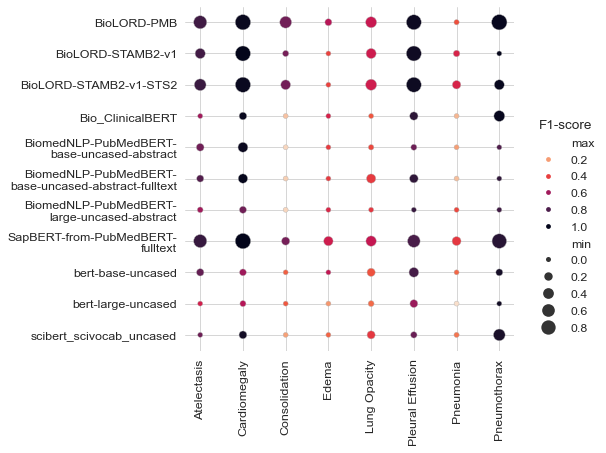

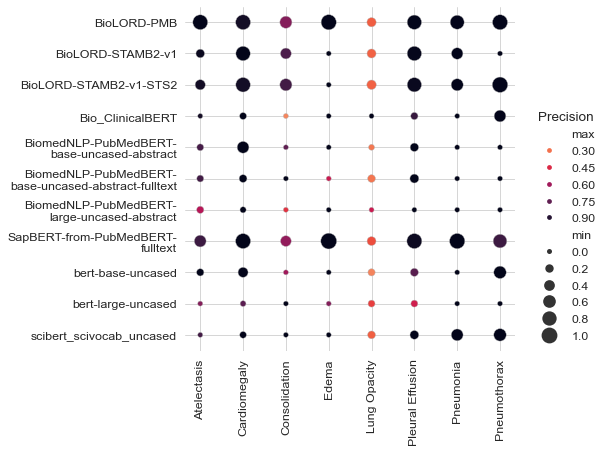

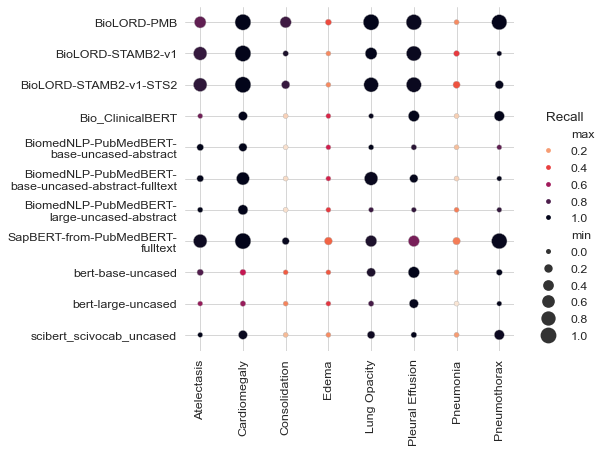

In [46]:
titles=['F1-score', 'Precision', 'Recall']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=6.4)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/ms-cxr_encoder_class_{metric}.png', dpi=600)

### B. Transcriptions
#### B.1. General analysis

In [109]:
dataset_name = 'transcriptions'

general_metrics = ['auc']
individual_metrics = ['c_auc']

In [110]:
df_results = results_encoder[results_encoder['data'] == dataset_name].copy()
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results[df_results['overflow'] == 'o'], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg|1|o],0.935409,[bert-large-uncased|CLS|0|o],0.480343


In [106]:
explore_results(df_results[df_results['overflow'] == ''], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg|1|],0.927391,[bert-large-uncased|CLS|0|],0.474296


General with template

In [70]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'pool', 'template', 'overflow', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'pool', 'template', 'overflow', 'data'], var_name='metric')

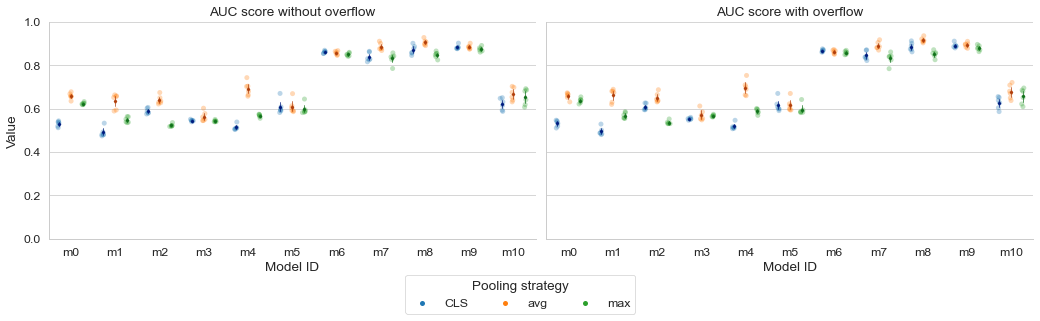

In [56]:
titles = ['AUC score without overflow', 'AUC score with overflow']

g = sns.catplot(df_results_long, x='modelID', y='value', hue='pool', col='overflow', col_wrap=2, dodge=True,
    alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, height=4, 
    aspect= 1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Pooling strategy', frameon=True)
plt.savefig('../../results/plots/transcriptions_encoder_general.png', bbox_inches='tight', dpi=600)

General without template

In [57]:
explore_results(df_results[(df_results['overflow'] == 'o') & (df_results['template'] == '')], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg||o],0.913703,[bert-large-uncased|CLS||o],0.528686


In [58]:
explore_results(df_results[(df_results['overflow'] == '') & (df_results['template'] == '')], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg||],0.906787,[bert-large-uncased|CLS||],0.532939


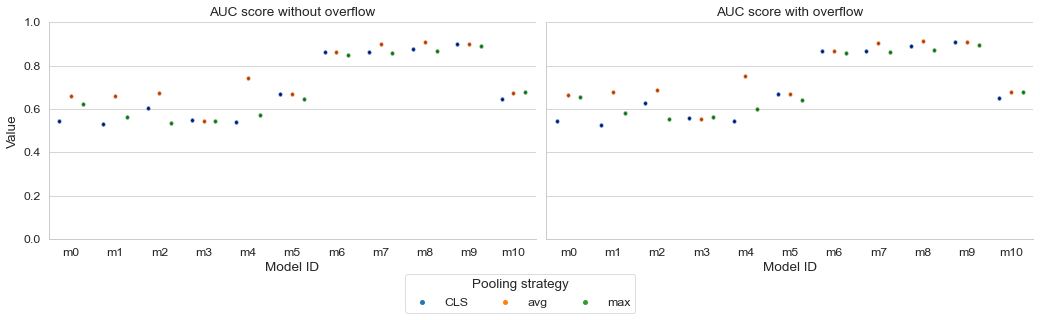

In [59]:
titles = ['AUC score without overflow', 'AUC score with overflow']

g = sns.catplot(df_results_long[df_results_long['template'] == ''], x='modelID', y='value', 
    hue='pool', col='overflow', col_wrap=2, dodge=True, alpha=.3, legend=True, zorder=1, 
    kind='strip', sharex=False, margin_titles=False, height=4, aspect=1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.12), ncol=4, title='Pooling strategy', frameon=True)
plt.tight_layout()
plt.savefig('../../results/plots/transcriptions_encoder_general_.png', bbox_inches='tight', dpi=600)

Detailed by overflow

In [60]:
temp = df_results_long[(df_results_long['template'] == '') & (df_results_long['overflow']=='')]\
    .merge(df_results_long[(df_results_long['template'] == '') & (df_results_long['overflow']=='o')], 
    on=['model', 'modelID', 'pool', 'template', 'data', 'metric'])
temp['diff'] = temp['value_y'] - temp['value_x']
print(temp['diff'].describe())
print('\nOverflow benefit or equal:', round((temp['diff'] >= 0).sum() / temp['diff'].shape[0], 4))
temp[temp['diff'] < 0]

count    33.000000
mean      0.009016
std       0.008045
min      -0.004253
25%       0.004424
50%       0.007749
75%       0.011750
max       0.029237
Name: diff, dtype: float64

Overflow benefit or equal: 0.8788


,model,modelID,pool,template,overflow_x,data,metric,value_x,overflow_y,value_y,diff
3,bert-large-uncased,m1,CLS,,,transcriptions,auc,0.532939,o,0.528686,-0.004253
15,scibert_scivocab_uncased,m5,CLS,,,transcriptions,auc,0.669938,o,0.669831,-0.000107
17,scibert_scivocab_uncased,m5,max,,,transcriptions,auc,0.643987,o,0.641877,-0.002110
32,Bio_ClinicalBERT,m10,max,,,transcriptions,auc,0.680707,o,0.679387,-0.001320


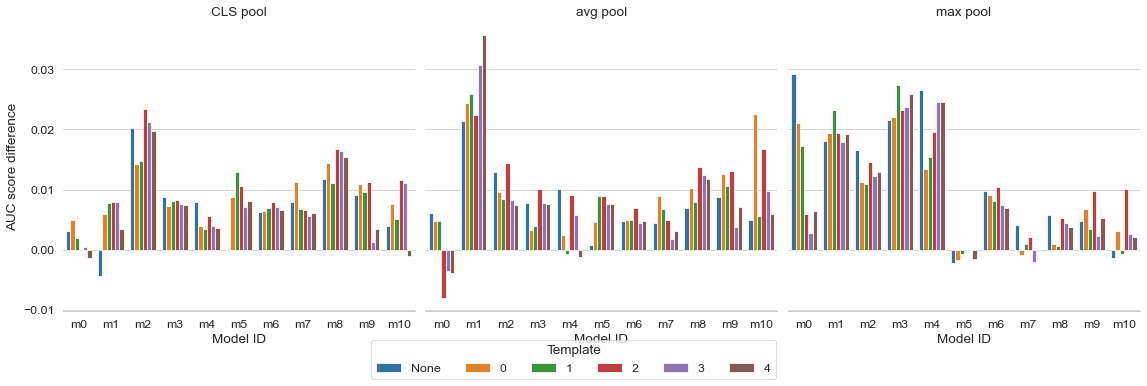

In [61]:
df_results['comparison'] = df_results.groupby(['model', 'pool', 'template'])['auc'].diff()

g = sns.catplot(df_results.dropna(subset='comparison').replace({'template': {'': 'None'}}),
    kind="bar", x="modelID", y="comparison", col="pool", hue='template')
g.set_axis_labels('Model ID', 'AUC score difference')
g.set_titles("{col_name} {col_var}")
g.despine(left=True)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.08), ncol=6, title='Template', frameon=True)
g.savefig('../../results/plots/transcriptions_encoder_diffs.png', bbox_inches='tight', dpi=600)

Detailed by template

In [62]:
titles = ['Template ' + (x if x != '' else 'none') for x in df_results['template'].drop_duplicates().values]
categories = df_results['modelID'].drop_duplicates().values.tolist()

fig = make_subplots(rows=2, cols=3, specs=[[{'type': 'polar'}] * 3] * 2, horizontal_spacing=0.1,
  vertical_spacing=0.1, subplot_titles=titles)

for i, template in enumerate(df_results['template'].drop_duplicates().values):
  for j, pool in enumerate(df_results['pool'].drop_duplicates().values):
    fig.add_trace(
      go.Scatterpolar(
        r=df_results.loc[(df_results['pool'] == pool) & (df_results['template'] == template) & 
          df_results['comparison'].notna(), 'auc'],
        theta=categories,
        name=pool,
        line=dict(color='rgb'+str(color_palette[j]), width=1),
        legendgroup=pool,
        showlegend=((i//3)+(i%3)==0)
      ),
      row=(i//3)+1, col=(i%3)+1
    )

fig.update_polars(
  radialaxis=dict(
    visible=True, range=[0, 1], tickfont = dict(size = 10)
  ),
  angularaxis=dict(
    tickangle=0, tickfont = dict(size = 10)
  )),

fig.update_layout(
  autosize=False, width=900, height=700,
  #title="AUC-score by template, model, and pooling strategy",
  #template='whi'
  legend=dict(
    title_text='Pooling strategy', orientation="h", yanchor="bottom", y=-0.1, xanchor="right", x=1
  ),
  margin=dict(l=30, r=30, t=30, b=0)
)
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

fig.show()
fig.write_image('../../results/plots/transcriptions_encoder_detail.png', scale=2)

In [71]:
r1 = df_results.fillna('')[df_results['overflow'] == 'o'].groupby(['model', 'template', 'pool'])['auc'].max().reset_index()
r2 = r1.merge(r1[r1['template'] == ''], on=['model', 'pool'])
r2['diff'] = r2['auc_x'] - r2['auc_y']
r3 = r2.groupby(['model', 'pool'])['diff'].agg(['min', 'max']).reset_index()

print('Metric: auc')
print('\n>> Best')
print(r2.merge(r3, left_on=['model', 'pool', 'diff'], right_on=['model', 'pool', 'min'])\
    .groupby('model')['template_x'].describe())
print('\n>> Worst')
print(r2.merge(r3, left_on=['model', 'pool', 'diff'], right_on=['model', 'pool', 'max'])\
    .groupby('model')['template_x'].describe())

Metric: auc

>> Best
                                                   count unique top freq
model                                                                   
BioLORD-PMB                                            3      1   3    3
BioLORD-STAMB2-v1                                      3      2   3    2
BioLORD-STAMB2-v1-STS2                                 3      2   3    2
Bio_ClinicalBERT                                       3      1   4    3
BiomedNLP-PubMedBERT-base-uncased-abstract             3      1   0    3
BiomedNLP-PubMedBERT-base-uncased-abstract-full...     3      2   0    2
BiomedNLP-PubMedBERT-large-uncased-abstract            3      1   0    3
SapBERT-from-PubMedBERT-fulltext                       3      1   4    3
bert-base-uncased                                      3      2   4    2
bert-large-uncased                                     3      3   0    1
scibert_scivocab_uncased                               3      3   0    1

>> Worst
                    

In [72]:
# Templates improving performance
r2.groupby("model").auc_x.max().reset_index().merge(r2)

,model,auc_x,template_x,pool,template_y,auc_y,diff
0,BioLORD-PMB,0.910730,,CLS,,0.910730,0.000000
1,BioLORD-STAMB2-v1,0.917045,1,avg,,0.904211,0.012834
2,BioLORD-STAMB2-v1-STS2,0.935409,1,avg,,0.913703,0.021706
3,Bio_ClinicalBERT,0.720403,0,avg,,0.679946,0.040457
4,BiomedNLP-PubMedBERT-base-uncased-abstract,0.611945,2,avg,,0.552746,0.059199
5,BiomedNLP-PubMedBERT-base-uncased-abstract-ful...,0.686916,,avg,,0.686916,0.000000
6,BiomedNLP-PubMedBERT-large-uncased-abstract,0.752739,,avg,,0.752739,0.000000
7,SapBERT-from-PubMedBERT-fulltext,0.875154,0,CLS,,0.867206,0.007948
8,bert-base-uncased,0.672714,1,avg,,0.665033,0.007681
9,bert-large-uncased,0.688957,1,avg,,0.680078,0.008879


#### B.2. Class analysis

In [112]:
df_class = create_perclass_df(df_results, ['model', 'pool', 'template', 'overflow'], 
    individual_metrics, n_classes)

In [113]:
df_class_long = pd.melt(df_class, id_vars=['model', 'pool', 'template', 'overflow', 'class'], 
    var_name='metric')
df_class_long.head()

,model,pool,template,overflow,class,metric,value
0,bert-base-uncased,CLS,,,0,c_auc,0.64227
1,bert-base-uncased,CLS,,,1,c_auc,0.640247
2,bert-base-uncased,CLS,,,2,c_auc,0.601897
3,bert-base-uncased,CLS,,,3,c_auc,0.496704
4,bert-base-uncased,CLS,,,4,c_auc,0.375961


In [114]:
labels_plot = ['Allergy or Immunology', 'Autopsy', 'Bariatrics', 'Cardiovascular or Pulmonary',
    'Cosmetic or Plastic Surgery', 'Dentistry', 'Dermatology', 'Diets and Nutritions', 'Endocrinology',
    'Gastroenterology', 'Hematology or Oncology', 'Laboratory Medicine\n or Clinical Pathology',
    'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics or Gynecology', 'Ophthalmology', 
    'Orthopedic', 'Otolaryngology', 'Pediatrics or Neonatal', 
    'Physical Medicine and \nRehabilitation, or Chiropractic', 'Podiatry', 'Psychiatry or Psychology',
    'Radiology', 'Rheumatology', 'Sleep Medicine', 'Speech and Language', 'Surgery', 'Urology']

df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(
    df_class['class'].drop_duplicates().values.tolist(), labels_plot)))
df_class_plot['model'] = df_class_plot['model'].replace(dict(zip(
    ['BiomedNLP-PubMedBERT-base-uncased-abstract', 'BiomedNLP-PubMedBERT-large-uncased-abstract', 
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-fulltext'], [
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract', 'BiomedNLP-PubMedBERT-\nlarge-uncased-abstract', 
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-\nfulltext'])))
df_class_plot = df_class_plot.sort_values(by='class')

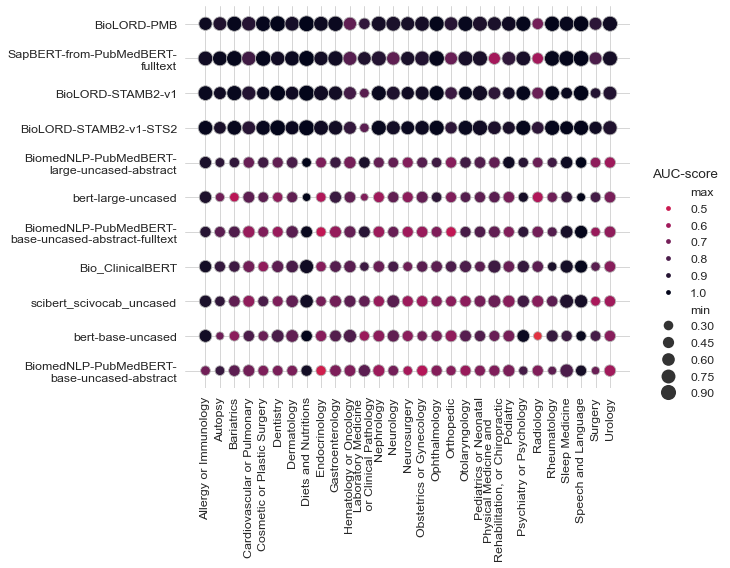

In [116]:
titles=['AUC-score']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=8)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/transcriptions_encoder_class_{metric}.png', dpi=600)

#### B.3. Reduced analysis

Set-up

In [118]:
# Most frequent classes
class_freq = np.vstack(data['transcriptions']['data']['target'].values).sum(axis=0)
class_sorted = sorted(zip(data['transcriptions']['labels'], range(len(class_freq)), class_freq), 
    key=lambda x:x[2])[-10:]
class_sorted

[('Otolaryngology', 18, 178.0),
 ('Neurosurgery', 14, 262.0),
 ('Urology', 28, 292.0),
 ('Obstetrics or Gynecology', 15, 294.0),
 ('Gastroenterology', 9, 431.0),
 ('Neurology', 13, 446.0),
 ('Radiology', 23, 607.0),
 ('Cardiovascular or Pulmonary', 3, 647.0),
 ('Orthopedic', 17, 765.0),
 ('Surgery', 27, 2283.0)]

In [119]:
stay_idx = [x[1] for x in sorted(class_sorted, key=lambda x:x[0])]
merge_idx = [x for x in range(len(data['transcriptions']['labels'])) if not(x in stay_idx)]

In [121]:
from tqdm import tqdm

def load_pickle(path:str):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

aux = ['', '0', '1', '2', '3', '4']
m_list = ["bert-base-uncased", "bert-large-uncased", "BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "BiomedNLP-PubMedBERT-base-uncased-abstract", "BiomedNLP-PubMedBERT-large-uncased-abstract",
    "SapBERT-from-PubMedBERT-fulltext", "Bio_ClinicalBERT", "BioLORD-STAMB2-v1", "BioLORD-STAMB2-v1-STS2",
    "BioLORD-PMB", "scibert_scivocab_uncased"]

results_encoder_mcqa = []
for d in ['transcriptions']:
    m_l = True
    keep_idx = data[d]['data'][~data[d]['data']['feature'].duplicated()].index
    target = np.vstack(data[d]['data'].loc[keep_idx, 'target'].apply(lambda x: np.array(x)).values)
    target = np.concatenate([target[:, stay_idx], np.any(target[:, merge_idx], axis=1, 
        keepdims=True).astype(int)], axis=1)

    for m in tqdm(m_list):
        for s in ['', '_o']:
            for p in ['CLS', 'max', 'avg']:
                file_path = f'../../results/temp/encode_{d}_{m}_{p}_pool'
                try:
                    d_ = load_from_disk(file_path + s)
                except:
                    continue
                if s == '_o':
                    d_ = aggregate_update_embedding(p, Dataset.from_pandas(data[d]['data'], 
                        preserve_index=False), d_, 'embedding').select(keep_idx)
                else:
                    d_ = d_.select(keep_idx)
                for t in aux:
                    t_ = load_pickle(file_path + f'_{t}.pkl')
                    t_mcqa = np.concatenate([t_['embedding'][stay_idx], 
                        np.mean(t_['embedding'][merge_idx], axis=0, keepdims=True)])
                    scores = cosine_similarity(torch.tensor(d_['embedding']), torch.tensor(t_mcqa))
                    results_encoder_mcqa.append([f'{m}_{p}_pool_{t}_{s[-1:]}', d] + 
                        measure_classification(target, scores, multilabel=m_l))

results_encoder_mcqa = pd.DataFrame(results_encoder_mcqa, columns=['model', 'data', 'accuracy', 
    'balanced_accuracy', 'accuracy_top3', 'accuracy_top5', 'auc', 'c_auc', 'f1', 'precision', 
    'recall', 'c_f1', 'c_precision', 'c_recall'])

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [09:31<00:00, 51.96s/it]


In [122]:
results_encoder_mcqa.head()

,model,data,accuracy,balanced_accuracy,accuracy_top3,accuracy_top5,auc,c_auc,f1,precision,recall,c_f1,c_precision,c_recall
0,bert-base-uncased_CLS_pool__,transcriptions,None,None,None,None,0.498292,"[0.49670392980201417, 0.5402352799227799, 0.55...",None,None,None,None,None,None
1,bert-base-uncased_CLS_pool_0_,transcriptions,None,None,None,None,0.488087,"[0.4768610332487619, 0.5377992277992278, 0.577...",None,None,None,None,None,None
2,bert-base-uncased_CLS_pool_1_,transcriptions,None,None,None,None,0.487547,"[0.48013098812465077, 0.5278812741312742, 0.59...",None,None,None,None,None,None
3,bert-base-uncased_CLS_pool_2_,transcriptions,None,None,None,None,0.483176,"[0.47459453984011096, 0.5257480694980695, 0.59...",None,None,None,None,None,None
4,bert-base-uncased_CLS_pool_3_,transcriptions,None,None,None,None,0.477717,"[0.4605753601144643, 0.5156503378378379, 0.578...",None,None,None,None,None,None


In [123]:
col_order = ['model', 'modelID', 'pool', 'template', 'overflow'] + results_encoder_mcqa.columns.to_list()[1:]
results_encoder_mcqa[['model', 'pool', 'template', 'overflow']] = list(results_encoder_mcqa.model.str.split('_')\
    .apply(lambda x: ('_'.join(x[:-4]), x[-4], x[-2], x[-1])))
models = results_encoder_mcqa['model'].drop_duplicates().values.tolist()
results_encoder_mcqa['modelID'] = results_encoder_mcqa['model'].replace({
    'bert-base-uncased': 0, 
    'bert-large-uncased': 1,
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': 2,
    'BiomedNLP-PubMedBERT-base-uncased-abstract': 3,
    'BiomedNLP-PubMedBERT-large-uncased-abstract': 4,
    'scibert_scivocab_uncased': 5,
    'SapBERT-from-PubMedBERT-fulltext': 6,
    'BioLORD-STAMB2-v1': 7, 
    'BioLORD-STAMB2-v1-STS2': 8, 
    'BioLORD-PMB': 9,
    'Bio_ClinicalBERT': 10
    }
)
results_encoder_mcqa = results_encoder_mcqa.sort_values(by=['data', 'overflow', 'modelID', 'pool'])
results_encoder_mcqa = results_encoder_mcqa[col_order]
results_encoder_mcqa['modelID'] = 'm' + results_encoder_mcqa['modelID'].astype(str)

In [130]:
results_encoder_mcqa.to_csv('../../results/results_encoder_r.csv', sep='|', index=False)

Analysis

In [124]:
df_results = results_encoder_mcqa[results_encoder_mcqa['data'] == dataset_name].copy()

explore_results(df_results[df_results['overflow'] == 'o'], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg|1|o],0.890128,[BiomedNLP-PubMedBERT-base-uncased-abstract|CL...,0.45803


In [125]:
explore_results(df_results[df_results['overflow'] == ''], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[BioLORD-STAMB2-v1-STS2|avg|1|],0.880701,[BiomedNLP-PubMedBERT-base-uncased-abstract|CL...,0.459708


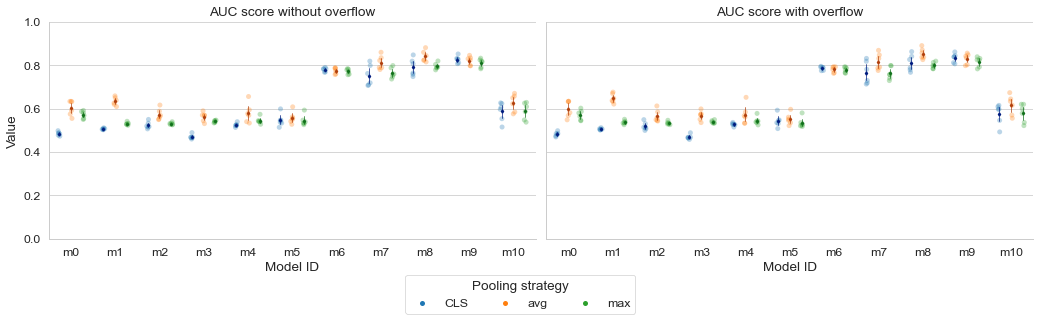

In [131]:
titles = ['AUC score without overflow', 'AUC score with overflow']
df_results_long = pd.melt(df_results[['model', 'modelID', 'pool', 'template', 'overflow', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'pool', 'template', 'overflow', 'data'], var_name='metric')
       
g = sns.catplot(df_results_long, x='modelID', y='value', hue='pool', col='overflow', col_wrap=2, 
    dodge=True, alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, 
    height=4, aspect=1.7)
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Pooling strategy', frameon=True)
plt.savefig('../../results/plots/transcriptions_encoder_general_r.png', bbox_inches='tight', dpi=600)

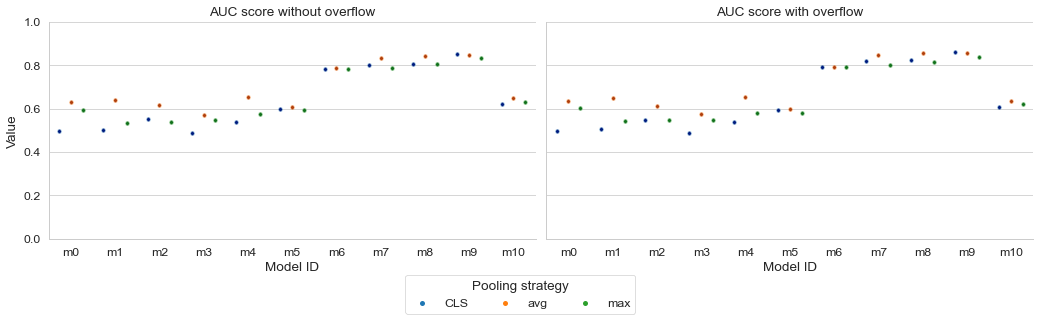

In [132]:
titles = ['AUC score without overflow', 'AUC score with overflow']

g = sns.catplot(df_results_long[df_results_long['template'] == ''], x='modelID', y='value', 
    hue='pool', col='overflow', col_wrap=2, dodge=True, alpha=.3, legend=True, zorder=1, 
    kind='strip', sharex=False, margin_titles=False, height=4, aspect= 1.7)
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='pool', dodge=.8 - .8 / 3, linestyle='none',
        palette="dark", markers="d", markersize=2, errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model ID', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Pooling strategy', frameon=True)
plt.savefig('../../results/plots/transcriptions_encoder_general_r_.png', bbox_inches='tight', dpi=600)

## NLI-based models
**Task:** Classification

**Datasets:** Transcriptions and MS-CXR

### Set-up

**Functions**

In [378]:
def explore_results(data, metrics):
    general = []
    for metric in metrics:
        idx_max = data[metric].where(data[metric] == data[metric].max()).dropna().index
        idx_min = data[metric].where(data[metric] == data[metric].min()).dropna().index
        general.append(dict(
            metric=metric,
            best_model=(data.loc[idx_max, 'model'] + '|' + data.loc[idx_max, 'template'] + '|' + 
                data.loc[idx_max, 'overflow'].astype(str)).values.tolist(),
            best_value=data[metric].loc[idx_max[0]],
            worst_model=(data.loc[idx_min, 'model'] + '|' + data.loc[idx_min, 'template'] + '|' + 
                data.loc[idx_min, 'overflow'].astype(str)).values.tolist(),
            worst_value=data[metric].loc[idx_min[0]],
        ))

    return pd.DataFrame(general)

**Results**

In [134]:
from tqdm import tqdm

# Option 1
aux = [['', '0', '1', '5', '6', '7'], ['', '0', '1', '2', '3', '4']]
m_list = ["nli-deberta-base", "bart-large-mnli", "roberta-large-mnli"]
excs = [[395, 407, 97], [[2,3], [2,3], [4,6]]]

results_nli = []
for i, d in enumerate(['ms-cxr', 'transcriptions']):
    m_l = d == 'transcriptions'
    keep_idx = data[d]['data'][~data[d]['data']['feature'].duplicated()].index
    n_classes = len(data[d]['labels'])
    for m in tqdm(m_list):
        for t in aux[i]:
            for s in ['', '_o']:
                try:
                    d_ = load_from_disk(f'../../results/temp/nli_{d}_{m}_{t}{s}')
                except:
                    continue
                if m_l:
                    scores = softmax(torch.tensor(d_['logits'])[:,[0,2]], dim=1)[:,1].view(-1,n_classes).numpy()
                    if 'overflow_to_sample_mapping' in d_.features:
                        scores = update_scores(scores, d_['overflow_to_sample_mapping'], func_name='mean')
                    scores = scores[keep_idx]
                else:
                    scores = softmax(torch.tensor(d_['logits'])[:,2].view(-1,n_classes)[keep_idx], dim=1).numpy()
                results_nli.append([f'{m}_{t}_{s[-1:]}', d] + measure_classification(
                    np.stack(data[d]['data'].loc[keep_idx, 'target'].values), scores, multilabel=m_l, 
                    exceptions=excs if d == 'ms-cxr' else None))

results_nli = pd.DataFrame(results_nli, columns=['model', 'data', 'accuracy', 'balanced_accuracy', 
    'accuracy_top3', 'accuracy_top5', 'auc', 'c_auc', 'f1', 'precision', 'recall', 'c_f1', 
    'c_precision', 'c_recall'])

# Option 2
#results_nli = pd.read_csv('../../results/results_nli.csv', sep='|')

100%|██████████| 3/3 [00:57<00:00, 19.17s/it]


In [135]:
results_nli.head()

,model,data,accuracy,balanced_accuracy,accuracy_top3,accuracy_top5,auc,c_auc,f1,precision,recall,c_f1,c_precision,c_recall
0,nli-deberta-base__,ms-cxr,0.212587,0.208086,0.369231,0.661538,NaN,None,0.139773,0.147279,0.208086,"[0.0, 0.11764705882352941, 0.10084033613445378...","[0.0, 0.08080808080808081, 0.35294117647058826...","[0.0, 0.21621621621621623, 0.05882352941176470..."
1,nli-deberta-base_0_,ms-cxr,0.121678,0.070282,0.281119,0.450350,NaN,None,0.048498,0.040938,0.070282,"[0.0, 0.03508771929824561, 0.0, 0.027586206896...","[0.0, 0.05, 0.0, 0.018691588785046728, 0.0, 0....","[0.0, 0.02702702702702703, 0.0, 0.052631578947..."
2,nli-deberta-base_1_,ms-cxr,0.124476,0.075854,0.250350,0.349650,NaN,None,0.064425,0.087135,0.075854,"[0.014814814814814815, 0.02061855670103093, 0....","[0.012658227848101266, 0.012738853503184714, 0...","[0.017857142857142856, 0.05405405405405406, 0...."
3,nli-deberta-base_5_,ms-cxr,0.179021,0.153155,0.490909,0.671329,NaN,None,0.132260,0.165046,0.153155,"[0.052173913043478265, 0.23333333333333334, 0....","[0.05084745762711865, 0.1686746987951807, 0.0,...","[0.05357142857142857, 0.3783783783783784, 0.0,..."
4,nli-deberta-base_6_,ms-cxr,0.145455,0.104969,0.327273,0.460140,NaN,None,0.102183,0.155903,0.104969,"[0.1095890410958904, 0.05940594059405941, 0.02...","[0.23529411764705882, 0.046875, 0.01875, 0.148...","[0.07142857142857142, 0.08108108108108109, 0.0..."


In [136]:
results_nli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              54 non-null     object 
 1   data               54 non-null     object 
 2   accuracy           18 non-null     float64
 3   balanced_accuracy  18 non-null     float64
 4   accuracy_top3      18 non-null     float64
 5   accuracy_top5      18 non-null     float64
 6   auc                36 non-null     float64
 7   c_auc              36 non-null     object 
 8   f1                 18 non-null     float64
 9   precision          18 non-null     float64
 10  recall             18 non-null     float64
 11  c_f1               18 non-null     object 
 12  c_precision        18 non-null     object 
 13  c_recall           18 non-null     object 
dtypes: float64(8), object(6)
memory usage: 6.0+ KB


In [137]:
col_order = ['model', 'modelID', 'template', 'overflow'] + results_nli.columns.to_list()[1:]
results_nli[['model', 'template', 'overflow']] = list(results_nli.model.str.split('_')\
    .apply(lambda x: ('_'.join(x[:-2]), x[-2], x[-1])))
models = results_nli['model'].drop_duplicates().values.tolist()

In [138]:
results_nli['modelID'] = results_nli['model'].replace({
    'nli-deberta-base': 0, 
    'roberta-large-mnli': 1,
    'bart-large-mnli': 2,
    }
)
results_nli = results_nli.sort_values(by=['data', 'overflow', 'modelID'])
results_nli = results_nli[col_order]
results_nli['modelID'] = 'm' + results_nli['modelID'].astype(str)

In [139]:
results_nli.to_csv('../../results/results_nli.csv', sep='|', index=False)

### A. MS-CXR
#### A.1. General analysis

General with template

In [140]:
dataset_name = 'ms-cxr'

general_metrics = ['accuracy', 'f1', 'precision', 'recall']
individual_metrics = ['c_f1', 'c_precision', 'c_recall']

In [141]:
df_results = results_nli[results_nli['data'] == dataset_name].copy()
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results, general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,accuracy,[roberta-large-mnli|5|],0.765035,[nli-deberta-base|0|],0.121678
1,f1,[roberta-large-mnli|5|],0.782459,[nli-deberta-base|0|],0.048498
2,precision,[roberta-large-mnli|5|],0.807359,[nli-deberta-base|0|],0.040938
3,recall,[roberta-large-mnli|5|],0.822759,[nli-deberta-base|0|],0.070282


In [142]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'template', 'overflow', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'template', 'overflow', 'data'], var_name='metric')
df_results_long['template_bool'] = df_results_long['template'] != ''

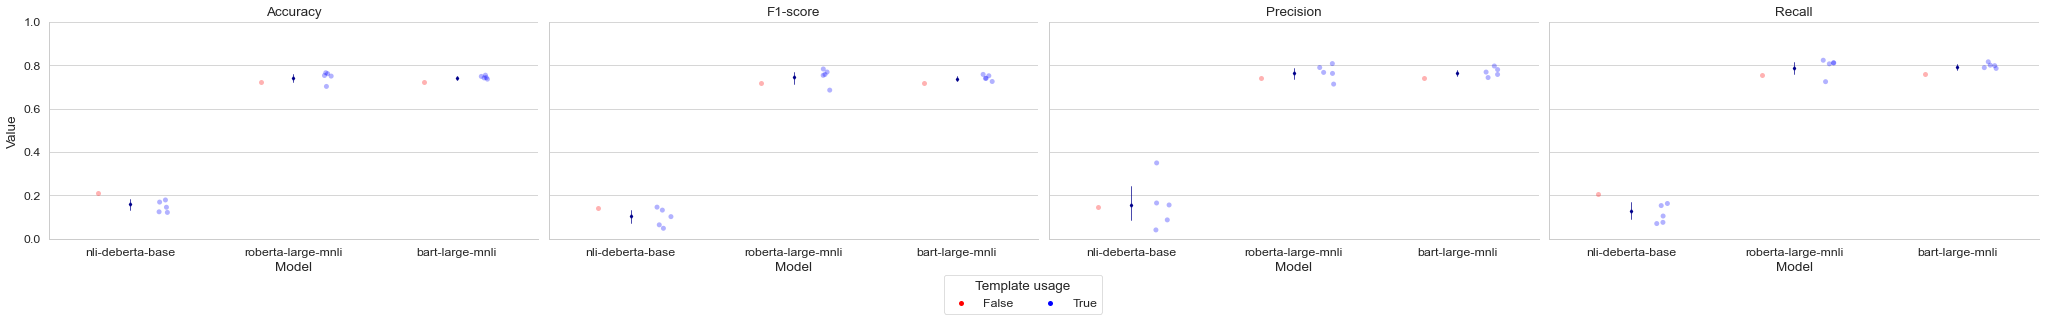

In [143]:
titles = ['Accuracy', 'F1-score', 'Precision', 'Recall']

g = sns.catplot(df_results_long, x='model', y='value', hue='template_bool', col='metric', col_wrap=4, 
    dodge=True, alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, 
    height=4, aspect= 1.7, palette=['red','blue'])
g.map_dataframe(sns.pointplot, x='model', y='value', linestyle='none', markers="d", markersize=2, 
        color='darkblue', errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Template usage', frameon=True)
plt.savefig('../../results/plots/ms-cxr_nli_general.png', bbox_inches='tight', dpi=600)

Detailed by template

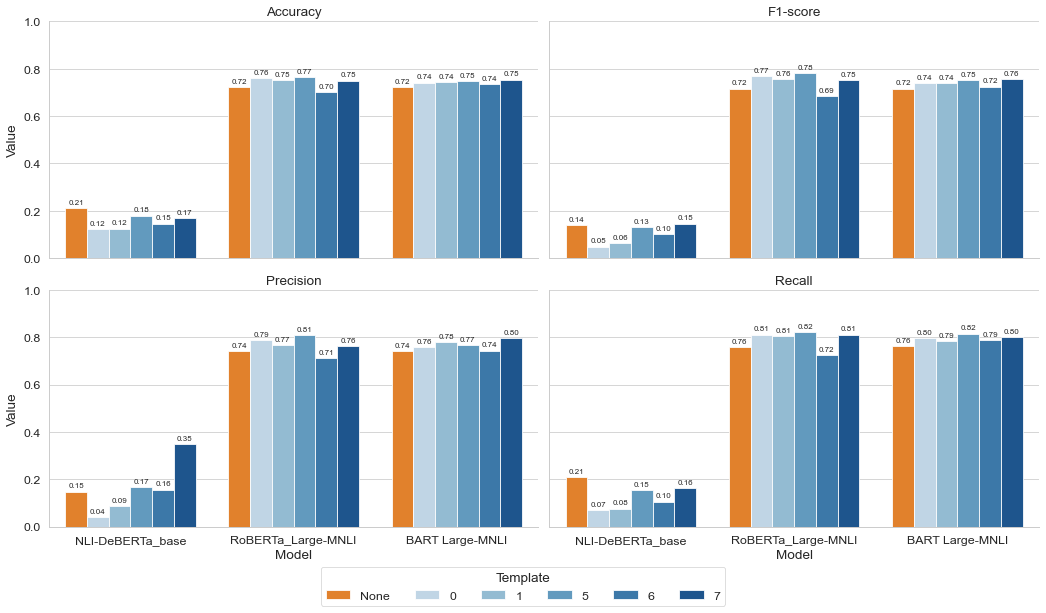

In [144]:

g = sns.catplot(df_results_long.replace({'template': {'': 'None'}, 'model': {
    'nli-deberta-base': 'NLI-DeBERTa_base', 'roberta-large-mnli':'RoBERTa_Large-MNLI', 
    'bart-large-mnli':'BART Large-MNLI'}}), x='model', y='value', 
    hue='template', col='metric', col_wrap=2, dodge=True, legend=True, zorder=1, kind='bar', 
    sharex=True, margin_titles=False, height=4, aspect= 1.7, palette=[color_palette[1], 
    blues_palette[1], blues_palette[2], blues_palette[3], blues_palette[4], blues_palette[5]])
g.set(ylim=(0, 1), xlabel='Model', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for ax in g.axes.ravel():
    for i in ax.containers:
        ax.bar_label(i, size=8, padding=3, fmt='%.2f')
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.07), ncol=6, title='Template', frameon=True)
plt.savefig('../../results/plots/ms-cxr_nli_detail.png', bbox_inches='tight', dpi=600)

In [145]:
r1 = df_results.fillna('').groupby(['model', 'template'])['f1'].max().reset_index()
r2 = r1.merge(r1[r1['template'] == ''], on=['model'])
r2['diff'] = r2['f1_x'] - r2['f1_y']

print('Metric: f1')
print('\n>> Full impact:')
print(r2.sort_values(by=['model', 'diff']))
print('\n>> Mean impact:')
print(r2.groupby('model')['diff'].mean())

Metric: f1

>> Full impact:
                 model template_x      f1_x template_y      f1_y      diff
0      bart-large-mnli             0.716271             0.716271  0.000000
4      bart-large-mnli          6  0.724835             0.716271  0.008564
1      bart-large-mnli          0  0.739085             0.716271  0.022814
2      bart-large-mnli          1  0.739630             0.716271  0.023359
3      bart-large-mnli          5  0.751189             0.716271  0.034918
5      bart-large-mnli          7  0.757493             0.716271  0.041222
7     nli-deberta-base          0  0.048498             0.139773 -0.091275
8     nli-deberta-base          1  0.064425             0.139773 -0.075348
10    nli-deberta-base          6  0.102183             0.139773 -0.037591
9     nli-deberta-base          5  0.132260             0.139773 -0.007513
6     nli-deberta-base             0.139773             0.139773  0.000000
11    nli-deberta-base          7  0.145955             0.139773  0.0061

#### A.2. Class analysis

In [146]:
df_class = create_perclass_df(df_results, ['model', 'template', 'overflow'], individual_metrics, 
    n_classes)
df_class.head()

,model,template,overflow,c_f1,c_precision,c_recall,class
0,nli-deberta-base,,,0.0,0.0,0.0,0
0,nli-deberta-base,,,0.117647,0.080808,0.216216,1
0,nli-deberta-base,,,0.10084,0.352941,0.058824,2
0,nli-deberta-base,,,0.482759,0.35443,0.756757,3
0,nli-deberta-base,,,0.0,0.0,0.0,4


In [147]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'overflow', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,overflow,class,metric,value
0,nli-deberta-base,,,0,c_f1,0.0
1,nli-deberta-base,,,1,c_f1,0.117647
2,nli-deberta-base,,,2,c_f1,0.10084
3,nli-deberta-base,,,3,c_f1,0.482759
4,nli-deberta-base,,,4,c_f1,0.0


In [148]:
df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(df_class_long['class'].drop_duplicates(), 
    data[dataset_name]['labels'])))
df_class_plot['model'] = df_class_plot['model'].replace(dict(zip(
    ['BiomedNLP-PubMedBERT-base-uncased-abstract', 'BiomedNLP-PubMedBERT-large-uncased-abstract', 
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-fulltext'], [
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract', 'BiomedNLP-PubMedBERT-\nlarge-uncased-abstract', 
    'BiomedNLP-PubMedBERT-\nbase-uncased-abstract-fulltext', 'SapBERT-from-PubMedBERT-\nfulltext'])))

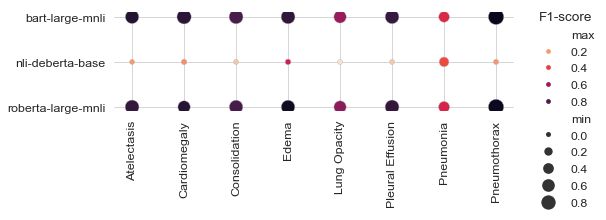

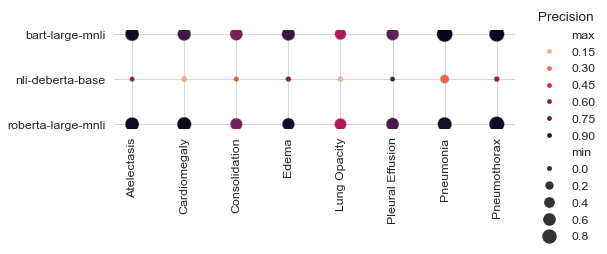

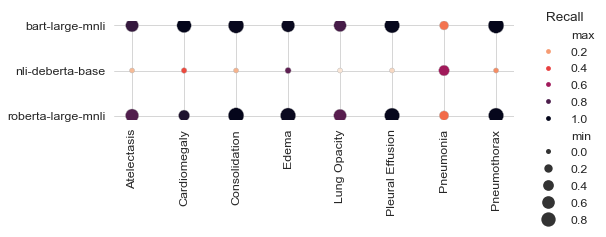

In [149]:
titles=['F1-score', 'Precision', 'Recall']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=6.4)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    g.fig.set_figheight(3)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/ms-cxr_nli_class_{metric}.png', dpi=600)

### B. Transcriptions
#### B.1. General analysis

General with template

In [150]:
dataset_name = 'transcriptions'

general_metrics = ['auc']
individual_metrics = ['c_auc']

In [151]:
df_results = results_nli[results_nli['data'] == dataset_name].copy().replace(
    {'overflow': {'': False, 'o': True}})
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results[df_results['overflow'] ==  False], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[bart-large-mnli|2|False],0.763348,[roberta-large-mnli||False],0.539936


In [152]:
explore_results(df_results[df_results['overflow'] == True], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[bart-large-mnli|2|True],0.805434,[nli-deberta-base||True],0.569061


In [153]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'template', 'overflow', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'template', 'overflow', 'data'], var_name='metric')
df_results_long['template_bool'] = df_results_long['template'] != ''

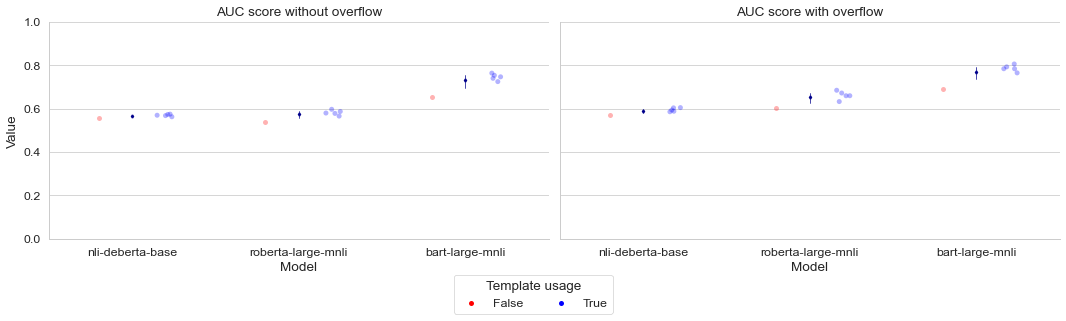

In [154]:
titles = ['AUC score without overflow', 'AUC score with overflow']

g = sns.catplot(df_results_long, x='model', y='value', hue='template_bool', col='overflow', col_wrap=2, 
    dodge=True, alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, 
    height=4, aspect= 1.7, palette=['red','blue'])
g.map_dataframe(sns.pointplot, x='model', y='value', linestyle='none', markers="d", markersize=2, 
        color='darkblue', errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), xlabel='Model', ylabel = 'Value')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Template usage', frameon=True)
plt.tight_layout()
plt.savefig('../../results/plots/transcriptions_nli_general.png', bbox_inches='tight', dpi=600)

Detailed by overflow

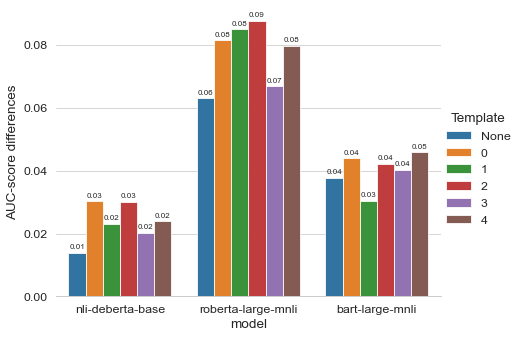

In [156]:
df_results['comparison'] = df_results.groupby(['model', 'template'])['auc'].diff()
g = sns.catplot(df_results.dropna(subset='comparison').replace({'template': {'': 'None'}}),
    kind="bar", x="model", y="comparison", hue='template', height=4.8, aspect= 1.33)
g.set_axis_labels('model', 'AUC-score differences')
g._legend.set_title('Template')
g.despine(left=True)
for i in g.axes[0]:
    for j in i.containers:
        i.bar_label(j, size=8, padding=3, fmt='%.2f')
g.savefig('../../results/plots/transcriptions_nli_diffs.png', dpi=600)

In [160]:
temp = df_results_long[(df_results_long['template'] == '') & (~df_results_long['overflow'])]\
    .merge(df_results_long[(df_results_long['template'] == '') & (df_results_long['overflow'])], 
    on=['model', 'modelID', 'template', 'data', 'metric'])
temp['diff'] = temp['value_y'] - temp['value_x']

print('Overflow benefit descriptives:')
print(temp['diff'].describe())
print('\nTotal overflow benefit (%):', round((temp['diff'] > 0).sum() / temp['diff'].shape[0], 4)*100)

Overflow benefit descriptives:
count    3.000000
mean     0.038182
std      0.024536
min      0.013888
25%      0.025797
50%      0.037706
75%      0.050329
max      0.062953
Name: diff, dtype: float64

Total overflow benefit (%): 100.0


Detailed by template

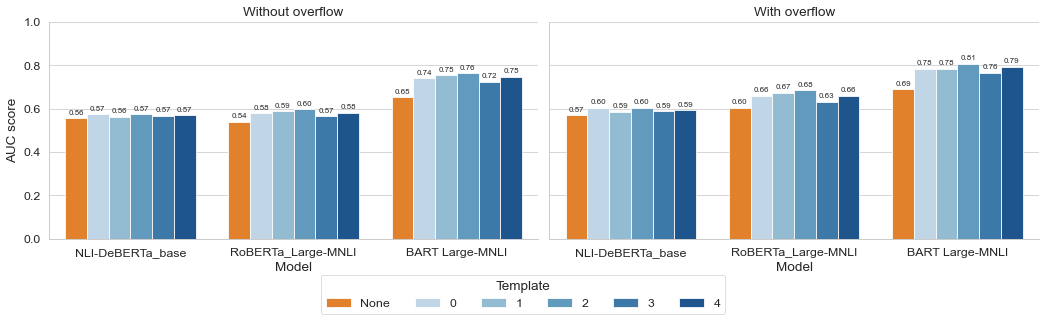

In [161]:
g = sns.catplot(df_results.replace({'template': {'': 'None'}, 'model': {
    'nli-deberta-base': 'NLI-DeBERTa_base', 'roberta-large-mnli':'RoBERTa_Large-MNLI', 
    'bart-large-mnli':'BART Large-MNLI'}}), kind='bar', x='model', y='auc',
    hue='template', col='overflow', dodge=True, legend=True, zorder=1, sharex=False, 
    margin_titles=False, height=4, aspect= 1.7, palette=[color_palette[1], blues_palette[1], 
    blues_palette[2], blues_palette[3], blues_palette[4], blues_palette[5]])
g.set_axis_labels('Model', 'AUC score')
plt.ylim(0, 1)
for ax, title in zip(g.axes.flatten(), ['Without overflow', 'With overflow']):
    ax.set_title(title)
for ax in g.axes.ravel():
    for i in ax.containers:
        ax.bar_label(i, size=8, padding=3, fmt='%.2f')
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=6, title='Template', frameon=True)
g.savefig('../../results/plots/transcriptions_nli_detail.png', bbox_inches='tight', dpi=600)

In [162]:
r1 = df_results.fillna('')[df_results['overflow'] == True].groupby(['model', 'template'])['auc'].max().reset_index()
r2 = r1.merge(r1[r1['template'] == ''], on=['model'])
r2['diff'] = r2['auc_x'] - r2['auc_y']

print('Metric: auc')
print('\n>> Full impact:')
print(r2.sort_values(by=['model', 'diff']))
print('\n>> Mean impact:')
print(r2.groupby('model')['diff'].mean())

Metric: auc

>> Full impact:
                 model template_x     auc_x template_y     auc_y      diff
0      bart-large-mnli             0.689510             0.689510  0.000000
4      bart-large-mnli          3  0.764457             0.689510  0.074947
1      bart-large-mnli          0  0.783456             0.689510  0.093946
2      bart-large-mnli          1  0.783648             0.689510  0.094137
5      bart-large-mnli          4  0.792183             0.689510  0.102673
3      bart-large-mnli          2  0.805434             0.689510  0.115923
6     nli-deberta-base             0.569061             0.569061  0.000000
8     nli-deberta-base          1  0.585331             0.569061  0.016270
10    nli-deberta-base          3  0.587784             0.569061  0.018723
11    nli-deberta-base          4  0.593243             0.569061  0.024182
7     nli-deberta-base          0  0.603279             0.569061  0.034219
9     nli-deberta-base          2  0.604492             0.569061  0.035

#### B.2. Class analysis

In [163]:
df_class = create_perclass_df(df_results, ['model', 'template', 'overflow'], 
    individual_metrics, n_classes)
df_class.head()

,model,template,overflow,c_auc,class
18,nli-deberta-base,,False,0.603013,0
18,nli-deberta-base,,False,0.631837,1
18,nli-deberta-base,,False,0.626243,2
18,nli-deberta-base,,False,0.568828,3
18,nli-deberta-base,,False,0.41213,4


In [164]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'overflow', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,overflow,class,metric,value
0,nli-deberta-base,,False,0,c_auc,0.603013
1,nli-deberta-base,,False,1,c_auc,0.631837
2,nli-deberta-base,,False,2,c_auc,0.626243
3,nli-deberta-base,,False,3,c_auc,0.568828
4,nli-deberta-base,,False,4,c_auc,0.41213


In [165]:
labels_plot = ['Allergy or Immunology', 'Autopsy', 'Bariatrics', 'Cardiovascular or Pulmonary',
    'Cosmetic or Plastic Surgery', 'Dentistry', 'Dermatology', 'Diets and Nutritions', 'Endocrinology',
    'Gastroenterology', 'Hematology or Oncology', 'Laboratory Medicine\n or Clinical Pathology',
    'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics or Gynecology', 'Ophthalmology', 
    'Orthopedic', 'Otolaryngology', 'Pediatrics or Neonatal', 
    'Physical Medicine and \nRehabilitation, or Chiropractic', 'Podiatry', 'Psychiatry or Psychology',
    'Radiology', 'Rheumatology', 'Sleep Medicine', 'Speech and Language', 'Surgery', 'Urology']

df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(
    df_class['class'].drop_duplicates().values.tolist(), labels_plot)))
df_class_plot = df_class_plot.sort_values(by='class')

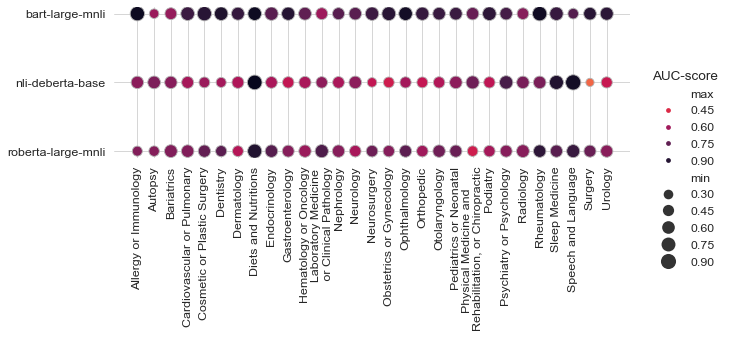

In [166]:
titles=['AUC-score']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=8)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    g.fig.set_figheight(4.8)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/trascriptions_nli_class_{metric}.png', dpi=600)

#### B.3. Reduced analysis

Set-up

In [167]:
class_freq = np.vstack(data['transcriptions']['data']['target'].values).sum(axis=0)
class_sorted = sorted(zip(data['transcriptions']['labels'], range(len(class_freq)), class_freq), 
    key=lambda x:x[2])[-10:]
class_sorted

[('Otolaryngology', 18, 178.0),
 ('Neurosurgery', 14, 262.0),
 ('Urology', 28, 292.0),
 ('Obstetrics or Gynecology', 15, 294.0),
 ('Gastroenterology', 9, 431.0),
 ('Neurology', 13, 446.0),
 ('Radiology', 23, 607.0),
 ('Cardiovascular or Pulmonary', 3, 647.0),
 ('Orthopedic', 17, 765.0),
 ('Surgery', 27, 2283.0)]

In [168]:
stay_idx = [x[1] for x in sorted(class_sorted, key=lambda x:x[0])]
merge_idx = [x for x in range(len(data['transcriptions']['labels'])) if not(x in stay_idx)]

In [169]:
from tqdm import tqdm

# Option 1
aux = ['', '0', '1', '2', '3', '4']
m_list = ["nli-deberta-base", "bart-large-mnli", "roberta-large-mnli"]

results_nli_mcqa = []
for d in ['transcriptions']:
    m_l = True
    keep_idx = data[d]['data'][~data[d]['data']['feature'].duplicated()].index
    n_classes = len(data[d]['labels'])
    target = np.stack(data[d]['data'].loc[keep_idx, 'target'].values)
    target = np.concatenate([target[:, stay_idx], np.any(target[:, merge_idx], axis=1, 
        keepdims=True).astype(int)], axis=1)
    for m in tqdm(m_list):
        for t in aux:
            for s in ['', '_o']:
                try:
                    d_ = load_from_disk(f'../../results/temp/nli_{d}_{m}_{t}{s}')
                except:
                    continue
                scores = softmax(torch.tensor(d_['logits'])[:,[0,2]], dim=1)[:,1].view(-1,n_classes).numpy()
                if 'overflow_to_sample_mapping' in d_.features:
                    scores = update_scores(scores, d_['overflow_to_sample_mapping'], func_name='mean')
                scores = np.concatenate([scores[keep_idx][:, stay_idx], 
                    np.max(scores[keep_idx][:, merge_idx], axis=1, keepdims=True)], axis=1)
                results_nli_mcqa.append([f'{m}_{t}_{s[-1:]}', d] + measure_classification(
                    target, scores, multilabel=m_l))

results_nli_mcqa = pd.DataFrame(results_nli_mcqa, columns=['model', 'data', 'accuracy', 'balanced_accuracy', 
    'accuracy_top3', 'accuracy_top5', 'auc', 'c_auc', 'f1', 'precision', 'recall', 'c_f1', 
    'c_precision', 'c_recall'])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:52<00:00, 17.54s/it]


In [170]:
results_nli_mcqa.head()

,model,data,accuracy,balanced_accuracy,accuracy_top3,accuracy_top5,auc,c_auc,f1,precision,recall,c_f1,c_precision,c_recall
0,nli-deberta-base__,transcriptions,None,None,None,None,0.469300,"[0.568828118446439, 0.4925506756756756, 0.6315...",None,None,None,None,None,None
1,nli-deberta-base__o,transcriptions,None,None,None,None,0.492521,"[0.5275754060141213, 0.4676737451737452, 0.603...",None,None,None,None,None,None
2,nli-deberta-base_0_,transcriptions,None,None,None,None,0.480037,"[0.5890002263327915, 0.5087982625482625, 0.646...",None,None,None,None,None,None
3,nli-deberta-base_0_o,transcriptions,None,None,None,None,0.517074,"[0.5528756135122259, 0.48247104247104244, 0.61...",None,None,None,None,None,None
4,nli-deberta-base_1_,transcriptions,None,None,None,None,0.474689,"[0.582216573574776, 0.5136003861003862, 0.6285...",None,None,None,None,None,None


In [171]:
results_nli_mcqa['time'] = np.nan
col_order = ['model', 'modelID', 'template', 'overflow'] + results_nli_mcqa.columns.to_list()[1:]
results_nli_mcqa[['model', 'template', 'overflow']] = list(results_nli_mcqa.model.str.split('_')\
    .apply(lambda x: ('_'.join(x[:-2]), x[-2], x[-1])))
models = results_nli_mcqa['model'].drop_duplicates().values.tolist()
results_nli_mcqa['modelID'] = results_nli_mcqa['model'].replace({
    'nli-deberta-base': 0, 
    'roberta-large-mnli': 1,
    'bart-large-mnli': 2,
    }
)
results_nli_mcqa = results_nli_mcqa.sort_values(by=['data', 'overflow', 'modelID'])
results_nli_mcqa = results_nli_mcqa[col_order]
results_nli_mcqa['modelID'] = 'm' + results_nli_mcqa['modelID'].astype(str)

In [172]:
results_nli_mcqa.to_csv('../../results/results_nli_r.csv', sep='|', index=False)

Analysis

In [412]:
df_results = results_nli_mcqa[results_nli_mcqa['data'] == dataset_name].copy()

explore_results(df_results[df_results['overflow'] == 'o'], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[bart-large-mnli|4|o],0.807489,[nli-deberta-base||o],0.492521


In [413]:
explore_results(df_results[df_results['overflow'] == ''], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[bart-large-mnli|2|],0.761877,[nli-deberta-base||],0.4693


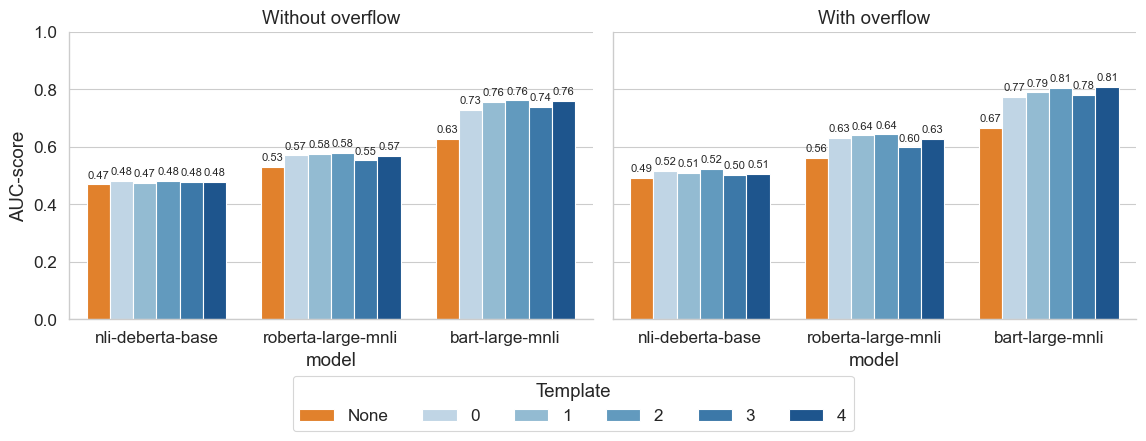

In [414]:
g = sns.catplot(df_results.replace({'template': {'': 'None'}}), kind='bar', x='model', y='auc',
    hue='template', col='overflow', dodge=True, legend=True, zorder=1, sharex=False, 
    margin_titles=False, height=4, aspect= 1.33, palette=[color_palette[1], blues_palette[1], 
    blues_palette[2], blues_palette[3], blues_palette[4], blues_palette[5]])
g.set_axis_labels('model', 'AUC-score')
plt.ylim(0, 1)
for ax, title in zip(g.axes.flatten(), ['Without overflow', 'With overflow']):
    ax.set_title(title)
for ax in g.axes.ravel():
    for i in ax.containers:
        ax.bar_label(i, size=8, padding=3, fmt='%.2f')
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=6, title='Template', frameon=True)
g.savefig('../../results/plots/transcriptions_nli_detail_r.png', bbox_inches='tight', dpi=600)

## Multiple-choice answering
**Task:** Classification

**Datasets:** Transcriptions and MS-CXR

### Set-up

**Functions**

In [309]:
def load_data(directory_path:str, file_path:str, feature_col:str=None, target_col:str=None,
    top_classes=None, multilabel=False):
    assert((feature_col is not None) and (target_col is not None)), \
        'Please specify both feature and target columns on the config.json file.'
    # Loading data
    dataset_df = load_csv_dataset(directory_path + file_path, feature_col, target_col)
    # Preprocessing datasets
    if 'transcriptions' in file_path: 
        # Proposed labels
        labels_norename = [
            'Autopsy', 'Bariatrics', 'Dentistry', 'Dermatology', 'Diets and Nutritions', 
            'Endocrinology', 'Gastroenterology', 'Nephrology', 'Neurology', 'Ophthalmology', 
            'Radiology', 'Sleep Medicine', 'Urology', 'Orthopedic', 'Neurosurgery', 'Podiatry', 
            'Rheumatology', 'Surgery'
        ]
        labels_rename = {
            'Allergy / Immunology': 'Allergy or Immunology',
            'Cardiovascular / Pulmonary': 'Cardiovascular or Pulmonary',
            'Chiropractic': 'Physical Medicine and Rehabilitation, or Chiropractic',
            'Cosmetic / Plastic Surgery': 'Cosmetic or Plastic Surgery',
            'ENT - Otolaryngology': 'Otolaryngology',
            'Hematology - Oncology': 'Hematology or Oncology',
            'Lab Medicine - Pathology': 'Laboratory Medicine or Clinical Pathology',
            'Obstetrics / Gynecology': 'Obstetrics or Gynecology',
            'Pediatrics - Neonatal': 'Pediatrics or Neonatal',
            'Physical Medicine - Rehab': 'Physical Medicine and Rehabilitation, or Chiropractic',
            'Psychiatry / Psychology': 'Psychiatry or Psychology',
            'Speech - Language': 'Speech and Language'
        }
        # Preprocessing targets: masking and renaming
        dataset_df = dataset_df.loc[dataset_df['target'].isin(labels_norename + list(labels_rename.keys()))]
        dataset_df.loc[:, 'target'] = dataset_df.loc[:, 'target'].replace(labels_rename).values.tolist()
        # Preporcessing features: cleaning
        dataset_df.loc[:, 'feature'] = dataset_df.loc[:, 'feature'].str.replace(' +', ' ', regex=True)\
            .str.replace(',(?=[A-z ]+:\s*,)', '\n\n', regex=True)\
            .str.replace(':\s*,\s*', ':\n', regex=True)\
            .str.replace('(?=.\s*),(?=[A-z0-9])' , '\n', regex=True).values.tolist()
    # Restricting to top classes
    if not(top_classes is None):
        top_values = dataset_df['target'].value_counts().sort_values(ascending=False)\
            .head(top_classes).index.sort_values().tolist()
        dataset_df.loc[~dataset_df['target'].isin(top_values), 'target'] = 'Other'
    # Defining labels
    dataset_df['target'] = dataset_df['target'].astype('category')
    if not(top_classes is None): 
        dataset_df['target'] = dataset_df['target'].cat.reorder_categories(top_values + ['Other'])
    labels = dataset_df['target'].cat.categories.tolist()
    dataset_df['target'] = dataset_df['target'].cat.codes
    if multilabel:
        n_classes = len(labels)
        temp = dataset_df.groupby('feature').target.apply(lambda x: binarized(x, n_classes)).reset_index()
        dataset_df = dataset_df[['feature']].merge(temp, on='feature', how='left')
    # Converting into dataset
    dataset = Dataset.from_pandas(dataset_df, preserve_index=False)

    return dataset, labels

In [310]:
def explore_results(data, metrics):
    general = []
    for metric in metrics:
        idx_max = data[metric].where(data[metric] == data[metric].max()).dropna().index
        idx_min = data[metric].where(data[metric] == data[metric].min()).dropna().index
        general.append(dict(
            metric=metric,
            best_model=(data.loc[idx_max, 'model'] + '|' + data.loc[idx_max, 'template'] + '|' + \
                data.loc[idx_max, 'question']).values.tolist(),
            best_value=data[metric].loc[idx_max[0]],
            worst_model=(data.loc[idx_min, 'model'] + '|' + data.loc[idx_min, 'template'] + '|' + \
                data.loc[idx_min, 'question']).values.tolist(),
            worst_value=data[metric].loc[idx_min[0]],
        ))

    return pd.DataFrame(general)

**Results**

In [311]:
with open('../config.json') as f:
        configuration = json.load(f)
data_path = configuration['data']['path']

data = {}
for dataset_name in ['ms-cxr', 'transcriptions']:
    dataset, labels = load_data(data_path, **configuration[dataset_name])
    data[dataset_name] = {
        'data': pd.DataFrame(dataset),
        'labels': labels
    }

In [312]:
mca = "list(map(chr, range(ord('A'), ord('Z') + 1)))"

In [313]:
from tqdm import tqdm

# Option 1
m_list = ["t5-v1_1-base", "t5-v1_1-large", "t5-v1_1-xl", "t5-v1_1-xxl", "flan-t5-base", "flan-t5-large", 
    "flan-t5-xl", "flan-t5-xxl", "T0_3B", "T0pp", "ClinicalT5-base", "ClinicalT5-large", "palmyra-base", 
    "camel-5b-hf", "gpt-j-6b", "instruct-gpt-j-fp16", "falcon-7b", "falcon-7b-instruct", "mpt-7b", 
    "mpt-7b-instruct", "llama-7b-hf", "llama-2-7b-hf", "alpaca-7b-hf", "llama-2-7b-chat-hf", "medalpaca-7b"]
excs = [[395, 407, 97], [[2,3], [2,3], [4,6]]]

aux = []
for i in [0, 1]:
    aux_mini = []
    for t in [['t01', 't02', 't03', 't04', 't07', 't11', 't13'], ['t01', 't02', 't03', 't04', 't07']][i]:
        if t in ['t04', 't11', 't13']:
            aux_mini.append(t)
            continue
        for q in [['q03', 'q04', 'q05'], ['q07', 'q08', 'q09']][i]:
            aux_mini.append(t + '_' + q)
    aux.append(aux_mini)

results_complete = []
results_extra = []
c_idx = []
for i, d in enumerate(['ms-cxr', 'transcriptions']):
    m_l = d == 'transcriptions'
    keep_idx = data[d]['data'][~data[d]['data']['feature'].duplicated()].index
    n_classes = len(data[d]['labels'])
    for m in tqdm(m_list):
        for t in aux[i]:
            d_ = load_from_disk(f'../../results/temp/complete_{d}_{m}_{t}')
            if m_l:
                results_complete.append([f'{m}_{t}', d] + measure_classification(
                    np.stack(data[d]['data'].loc[keep_idx, 'target'].values), 
                    np.max(np.array(d_['logits_c']).reshape(-1, 11, 2, order='F'), axis=-1),
                    multilabel=m_l))
            else:
                d_ = d_.map(lambda x: {'predicted': text2label(x['decoded_c'], labels, mca),
                    'extra': text2label(x['decoded'], labels, mca)}, batched=True)
                results_complete.append([f'{m}_{t}', d] + measure_classification(
                    data[d]['data'].loc[keep_idx, 'target'].values, d_['predicted'], 
                    as_score=False, multilabel=m_l, exceptions=excs))
                results_extra.append([f'{m}_{t}', d] + measure_classification(
                    data[d]['data'].loc[keep_idx, 'target'].values, d_['extra'], 
                    as_score=False, multilabel=m_l, exceptions=excs))
                c_idx.append(torch.tensor(d_['logits_c']).argmax(dim=1))

results_complete = pd.DataFrame(results_complete, columns=['model', 'data', 'accuracy', 
    'balanced_accuracy', 'accuracy_top3', 'accuracy_top5', 'auc', 'c_auc', 'f1', 'precision', 
    'recall', 'c_f1', 'c_precision', 'c_recall'])

# Option 2
#results_complete = pd.read_csv('../../results/results_complete.csv', sep='|')

  0%|          | 0/25 [00:00<?, ?it/s]Loading cached processed dataset at c:\Users\andre\Documents\TUM\Semester3\guided-research\results\temp\complete_ms-cxr_t5-v1_1-base_t01_q03\cache-315e63c7eb2d6342.arrow
c:\Users\andre\anaconda3\envs\i2dl\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning:

y_pred contains classes not in y_true

Loading cached processed dataset at c:\Users\andre\Documents\TUM\Semester3\guided-research\results\temp\complete_ms-cxr_t5-v1_1-base_t01_q04\cache-feafeb0d2ade6a9c.arrow
c:\Users\andre\anaconda3\envs\i2dl\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning:

y_pred contains classes not in y_true

Loading cached processed dataset at c:\Users\andre\Documents\TUM\Semester3\guided-research\results\temp\complete_ms-cxr_t5-v1_1-base_t01_q05\cache-9bb185bc37ea77ac.arrow
c:\Users\andre\anaconda3\envs\i2dl\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning:

y_pred contains classes not in y_true

Loading cac

In [314]:
results_complete.head()

,model,data,accuracy,balanced_accuracy,accuracy_top3,accuracy_top5,auc,c_auc,f1,precision,recall,c_f1,c_precision,c_recall
0,t5-v1_1-base_t01_q03,ms-cxr,0.078322,0.125,None,None,NaN,None,0.018158,0.00979,0.125,"[0.14526588845654995, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.07832167832167833, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,t5-v1_1-base_t01_q04,ms-cxr,0.078322,0.125,None,None,NaN,None,0.018158,0.00979,0.125,"[0.14526588845654995, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.07832167832167833, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,t5-v1_1-base_t01_q05,ms-cxr,0.078322,0.125,None,None,NaN,None,0.018158,0.00979,0.125,"[0.14526588845654995, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.07832167832167833, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,t5-v1_1-base_t02_q03,ms-cxr,0.078322,0.125,None,None,NaN,None,0.018158,0.00979,0.125,"[0.14526588845654995, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.07832167832167833, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,t5-v1_1-base_t02_q04,ms-cxr,0.078322,0.125,None,None,NaN,None,0.018158,0.00979,0.125,"[0.14526588845654995, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.07832167832167833, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [315]:
results_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              700 non-null    object 
 1   data               700 non-null    object 
 2   accuracy           375 non-null    float64
 3   balanced_accuracy  375 non-null    float64
 4   accuracy_top3      0 non-null      object 
 5   accuracy_top5      0 non-null      object 
 6   auc                325 non-null    float64
 7   c_auc              325 non-null    object 
 8   f1                 375 non-null    float64
 9   precision          375 non-null    float64
 10  recall             375 non-null    float64
 11  c_f1               375 non-null    object 
 12  c_precision        375 non-null    object 
 13  c_recall           375 non-null    object 
dtypes: float64(6), object(8)
memory usage: 76.7+ KB


In [316]:
col_order = ['model', 'modelID', 'template', 'question'] + results_complete.columns.to_list()[1:]
results_complete[['model', 'template']] = list(results_complete.model.str.split('_t').apply(lambda x: (x[-2], 't' + x[-1])))
results_complete[['template', 'question']] = list(results_complete.template.str.split('_q').apply(lambda x: (x[0], 'q' + x[-1] if len(x) > 1 else '')))
models = results_complete['model'].drop_duplicates().values.tolist()
results_complete['modelID'] = results_complete['model'].replace(dict([(m, 'm'+ str(i)) for i, m in enumerate(models)]))
results_complete = results_complete[col_order]

In [317]:
results_complete.to_csv('../../results/results_complete.csv', sep='|', index=False)

### A. MS-CXR
#### A.1. General analysis

In [318]:
dataset_name = 'ms-cxr'

general_metrics = ['accuracy', 'f1', 'precision', 'recall']
individual_metrics = ['c_f1', 'c_precision', 'c_recall']

In [319]:
df_results = results_complete[results_complete['data'] == dataset_name].copy()
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results, general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,accuracy,"[T0pp|t03|q04, T0pp|t03|q05]",0.816783,[camel-5b-hf|t07|q05],0.048951
1,f1,[T0pp|t03|q05],0.838957,"[falcon-7b-instruct|t02|q03, falcon-7b-instruc...",0.012301
2,precision,[alpaca-7b-hf|t02|q03],0.858492,"[falcon-7b-instruct|t02|q03, falcon-7b-instruc...",0.006469
3,recall,[T0pp|t03|q04],0.891824,[camel-5b-hf|t07|q05],0.081564


In [320]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'template', 'question', 'data'] + general_metrics],
       id_vars=['model', 'modelID', 'template', 'question', 'data'], var_name='metric')
df_results_long['model_family'] = 'Generative general models'
df_results_long.loc[df_results_long['model'].str.lower().str.contains('t5') | 
       df_results_long['model'].str.lower().str.contains('t0'), 'model_family'] = 'T5 models'
df_results_long.loc[df_results_long['model'].str.lower().str.contains('llama') | 
       df_results_long['model'].str.lower().str.contains('alpaca'), 'model_family'] = 'LLaMA models'

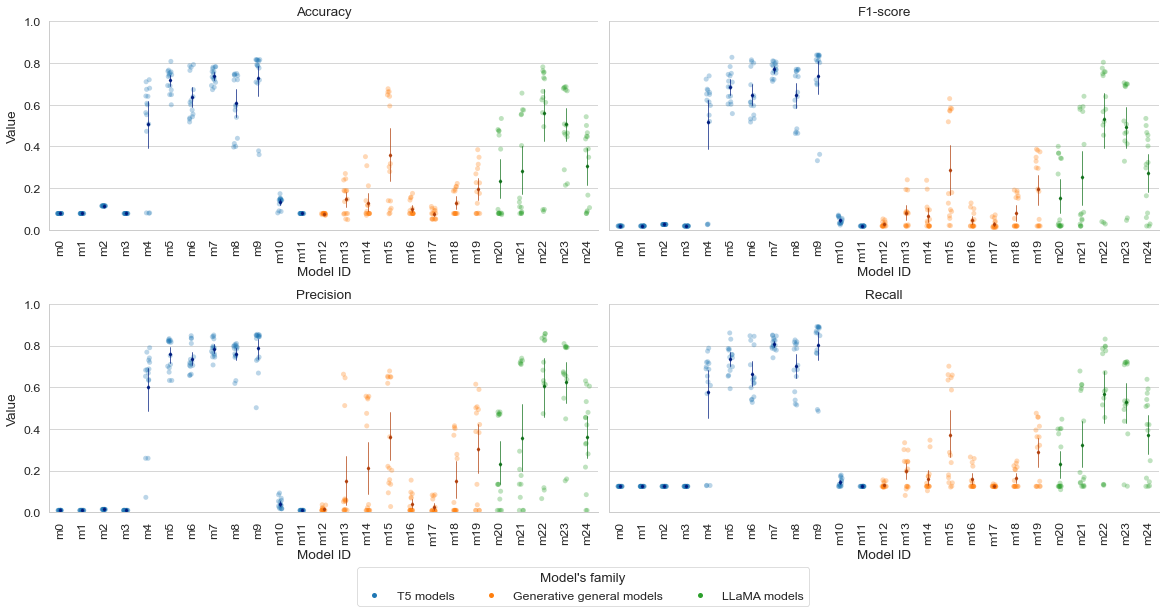

In [321]:
titles = ['Accuracy', 'F1-score', 'Precision', 'Recall']

g = sns.catplot(df_results_long, x='modelID', y='value', hue='model_family', col='metric', col_wrap=2, 
    dodge=False, alpha=.3, legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, 
    height=4, aspect=1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='model_family', linestyle='none', 
    markers="d", markersize=2, palette="dark", errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), ylabel='Value', xlabel='Model ID')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.07), ncol=3, title="Model's family", frameon=True)
plt.savefig('../../results/plots/ms-cxr_complete_general.png',  bbox_inches='tight', dpi=600)

High performance

In [322]:
df_max = df_results.groupby('model')['f1'].agg(['max', 'std']).sort_values(by='max')
print(df_max)
print('\nPercentage below random: ', ((df_max['max'] < 0.125).sum() - 5)/(df_max.shape[0] - 5))

                          max       std
model                                  
t5-v1_1-xxl          0.018158  0.000000
ClinicalT5-large     0.018158  0.000000
t5-v1_1-large        0.018158  0.000000
t5-v1_1-base         0.018158  0.000000
t5-v1_1-xl           0.025721  0.000000
palmyra-base         0.052252  0.011792
ClinicalT5-base      0.070580  0.015809
falcon-7b-instruct   0.071703  0.020982
falcon-7b            0.128772  0.039607
mpt-7b               0.190895  0.076552
gpt-j-6b             0.237724  0.069527
camel-5b-hf          0.240011  0.072071
mpt-7b-instruct      0.386748  0.156405
llama-7b-hf          0.400551  0.166861
medalpaca-7b         0.534425  0.193169
instruct-gpt-j-fp16  0.629613  0.250416
llama-2-7b-hf        0.640837  0.267041
llama-2-7b-chat-hf   0.705644  0.220414
flan-t5-base         0.738792  0.259983
T0_3B                0.770617  0.124466
alpaca-7b-hf         0.804175  0.279292
flan-t5-xxl          0.810883  0.032420
flan-t5-xl           0.815556  0.106514


Low performance

In [323]:
df_min = df_results.groupby('model')['f1'].min().sort_values()
print(df_min)
print('\nPercentage below random: ', ((df_min < 0.125).sum() - 5)/(df_min.shape[0] - 5))

model
falcon-7b-instruct     0.012301
camel-5b-hf            0.017419
gpt-j-6b               0.018158
t5-v1_1-large          0.018158
t5-v1_1-base           0.018158
palmyra-base           0.018158
mpt-7b-instruct        0.018158
mpt-7b                 0.018158
medalpaca-7b           0.018158
llama-7b-hf            0.018158
llama-2-7b-hf          0.018158
t5-v1_1-xxl            0.018158
falcon-7b              0.018158
ClinicalT5-large       0.018158
instruct-gpt-j-fp16    0.019935
ClinicalT5-base        0.022991
flan-t5-base           0.024687
t5-v1_1-xl             0.025721
alpaca-7b-hf           0.027884
llama-2-7b-chat-hf     0.045453
T0pp                   0.331748
T0_3B                  0.462342
flan-t5-xl             0.517181
flan-t5-large          0.557706
flan-t5-xxl            0.712691
Name: f1, dtype: float64

Percentage below random:  0.75


Analysis of differences

In [324]:
df_both = df_max.reset_index().merge(df_min.reset_index(), on='model')
df_both['diff'] = df_both['max'] - df_both['f1']
df_both.describe()

,max,std,f1,diff
count,25.000000,25.000000,25.000000,25.000000
mean,0.399802,0.104242,0.119838,0.279964
std,0.328187,0.097018,0.210226,0.255585
min,0.018158,0.000000,0.012301,0.000000
25%,0.070580,0.015809,0.018158,0.047589
50%,0.386748,0.076043,0.018158,0.222592
75%,0.738792,0.166861,0.027884,0.507209
max,0.838957,0.279292,0.712691,0.776291


<Axes: >

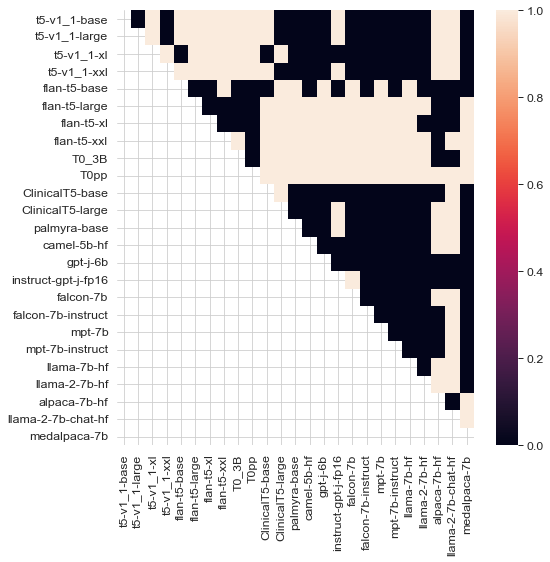

In [325]:
res = [(a, b) for idx, a in enumerate(models) for b in models[idx + 1:]]
resdf = pd.DataFrame(columns=models, index=models, dtype=int)

for x in res:
    temp = df_results.loc[df_results['model'] == x[0], ['model', 'template', 'question', 'f1']].merge(
        df_results.loc[df_results['model'] == x[1], ['model', 'template', 'question', 'f1']],
        on=['template', 'question'])
    resdf.loc[x[0], x[1]] = int(all((temp['f1_y'] - temp['f1_x']) > 0) | all((temp['f1_y'] - temp['f1_x']) < 0))

plt.figure(figsize=(8,8))
sns.heatmap(resdf)

In [326]:
aux = [('t5-v1_1-base', 'flan-t5-base'),
    ('t5-v1_1-large', 'flan-t5-large'),
    ('t5-v1_1-xl', 'flan-t5-xl'),
    ('t5-v1_1-xl', 'T0_3B'),
    ('t5-v1_1-xxl', 'flan-t5-xxl'),
    ('t5-v1_1-xxl', 'T0pp'),
    ('ClinicalT5-base', 'flan-t5-base'),
    ('ClinicalT5-large', 'flan-t5-large'),
    ('palmyra-base', 'camel-5b-hf'),
    ('gpt-j-6b', 'instruct-gpt-j-fp16'),
    ('falcon-7b', 'falcon-7b-instruct'),
    ('mpt-7b', 'mpt-7b-instruct'),
    ('llama-7b-hf', 'alpaca-7b-hf'),
    ('llama-7b-hf', 'llama-2-7b-chat-hf'),
    ('llama-7b-hf', 'medalpaca-7b'),
    ('llama-2-7b-hf', 'alpaca-7b-hf'),
    ('llama-2-7b-hf', 'llama-2-7b-chat-hf'),
    ('llama-2-7b-hf', 'medalpaca-7b')]

print('>> f1 mean differences:')
temp = df_results.groupby('model')['f1'].mean().reset_index().merge(df_results.groupby('model')['f1']\
    .mean().reset_index().rename(columns={'model': 'model_x', 'f1': 'f1_x'}), how='cross')
temp['diff'] = temp['f1_x'] - temp['f1']
filter_ = np.zeros(temp.shape[0])
for i in aux:
    filter_[temp.loc[(temp['model'] == i[0]) & (temp['model_x'] == i[1]), ['model', 'diff']].index] = 1
print(temp[filter_.astype(bool)]['diff'].describe())

print('\n>> f1 max differences:')
temp = df_results.groupby('model')['f1'].max().reset_index().merge(df_results.groupby('model')['f1']\
    .max().reset_index().rename(columns={'model': 'model_x', 'f1': 'f1_x'}), how='cross')
temp['diff'] = temp['f1_x'] - temp['f1']
filter_ = np.zeros(temp.shape[0])
for i in aux:
    filter_[temp.loc[(temp['model'] == i[0]) & (temp['model_x'] == i[1]), ['model', 'diff']].index] = 1
print(temp[filter_.astype(bool)]['diff'].describe())

>> f1 mean differences:
count    18.000000
mean      0.376116
std       0.259793
min      -0.017041
25%       0.144303
50%       0.358257
75%       0.622599
max       0.751923
Name: diff, dtype: float64

>> f1 max differences:
count    18.000000
mean      0.435525
std       0.333474
min      -0.106412
25%       0.169443
50%       0.397756
75%       0.778600
max       0.820799
Name: diff, dtype: float64


Analysis of prompt

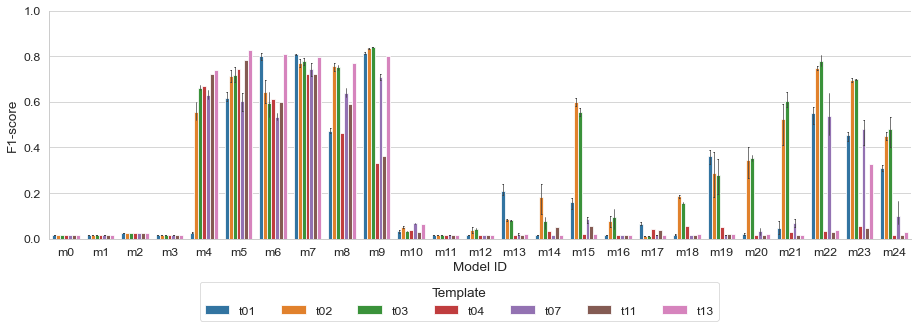

In [327]:
g = sns.catplot(data=df_results, x="modelID", y="f1", hue="template", capsize=.15, aspect=3, 
    err_kws={'linewidth': 0.7}, kind='bar', height=4)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.xlabel('Model ID')
plt.ylabel('F1-score')
plt.ylim([0,1])
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.15), ncol=7, title="Template", frameon=True)
plt.savefig('../../results/plots/ms-cxr_complete_detail_template.png',  bbox_inches='tight', dpi=600)

In [328]:
df_results[['template', 'model', 'f1']].groupby(['template', 'model'])['f1'].mean().reset_index()\
    .groupby('model')['f1'].std().describe()

count    25.000000
mean      0.110153
std       0.106976
min       0.000000
25%       0.015715
50%       0.072616
75%       0.207738
max       0.343489
Name: f1, dtype: float64

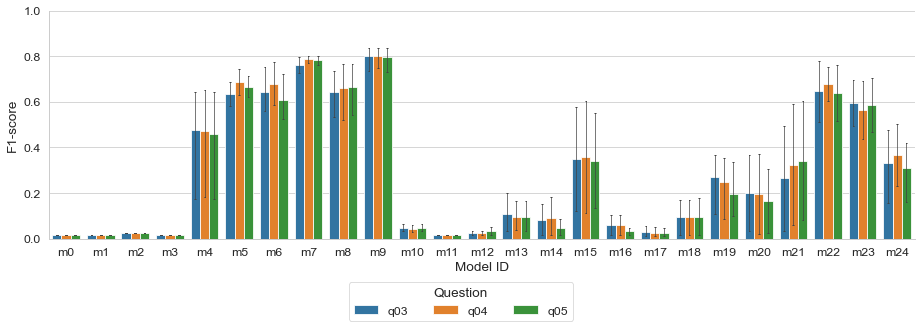

In [329]:
g = sns.catplot(data=df_results[df_results['question'] != ''], x="modelID", y="f1", hue="question", 
    capsize=.15, aspect=3, err_kws={'linewidth': 0.7}, kind='bar', height=4)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.xlabel('Model ID')
plt.ylabel('F1-score')
plt.ylim([0,1])
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.15), ncol=3, title="Question", frameon=True)
plt.savefig('../../results/plots/ms-cxr_complete_detail_question.png', bbox_inches='tight', dpi=600)

In [330]:
df_results[['model', 'f1', 'template']].groupby(['model', 'template'])['f1'].std().dropna() \
    .reset_index().describe()

,f1
count,100.000000
mean,0.017446
std,0.023344
min,0.000000
25%,0.000000
50%,0.008347
75%,0.026592
max,0.098935


#### A.2. Class analysis

In [331]:
df_class = create_perclass_df(df_results, ['model', 'template', 'question'], 
    individual_metrics, n_classes)
df_class.head()

,model,template,question,c_f1,c_precision,c_recall,class
0,t5-v1_1-base,t01,q03,0.145266,0.078322,1.0,0
0,t5-v1_1-base,t01,q03,0.0,0.0,0.0,1
0,t5-v1_1-base,t01,q03,0.0,0.0,0.0,2
0,t5-v1_1-base,t01,q03,0.0,0.0,0.0,3
0,t5-v1_1-base,t01,q03,0.0,0.0,0.0,4


In [332]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'question', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,question,class,metric,value
0,t5-v1_1-base,t01,q03,0,c_f1,0.145266
1,t5-v1_1-base,t01,q03,1,c_f1,0.0
2,t5-v1_1-base,t01,q03,2,c_f1,0.0
3,t5-v1_1-base,t01,q03,3,c_f1,0.0
4,t5-v1_1-base,t01,q03,4,c_f1,0.0


In [333]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'question', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,question,class,metric,value
0,t5-v1_1-base,t01,q03,0,c_f1,0.145266
1,t5-v1_1-base,t01,q03,1,c_f1,0.0
2,t5-v1_1-base,t01,q03,2,c_f1,0.0
3,t5-v1_1-base,t01,q03,3,c_f1,0.0
4,t5-v1_1-base,t01,q03,4,c_f1,0.0


In [334]:
df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(df_class_long['class'].drop_duplicates(), 
    data[dataset_name]['labels'])))

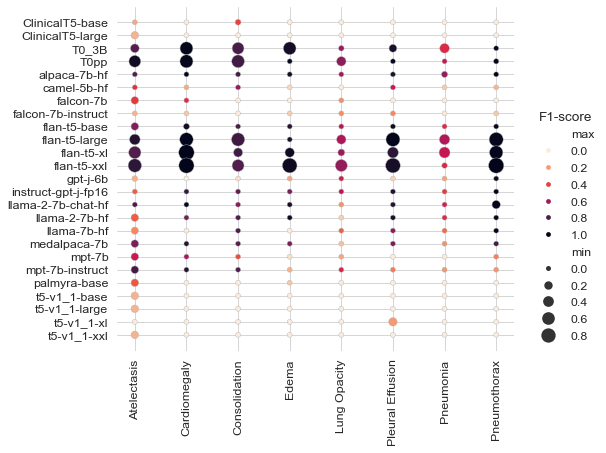

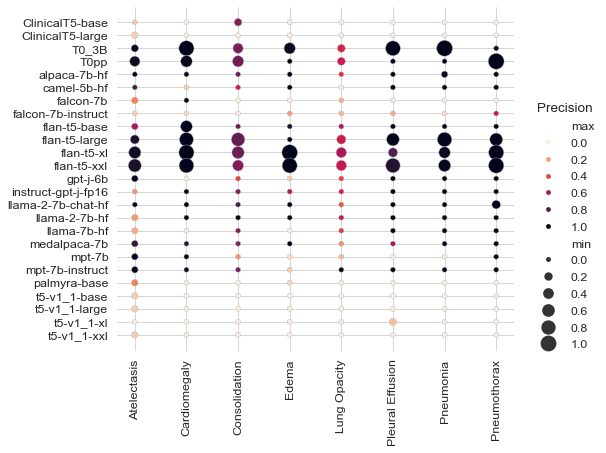

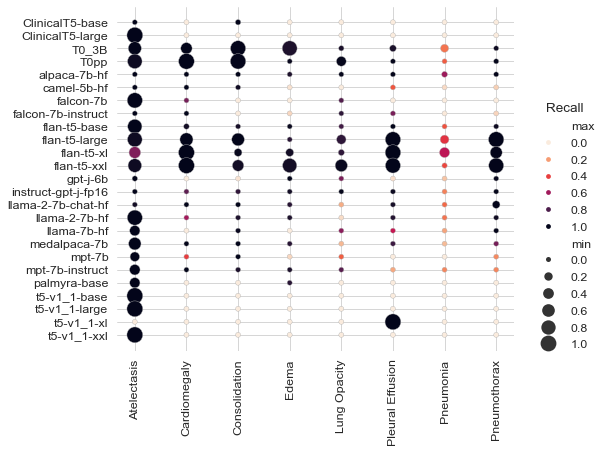

In [335]:
titles=['F1-score', 'Precision', 'Recall']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=6.4)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/ms-cxr_complete_class_{metric}.png', dpi=600)

### B. Transcriptions
#### B.1. General analysis

In [336]:
dataset_name = 'transcriptions'

general_metrics = ['auc']
individual_metrics = ['c_auc']

In [337]:
df_results = results_complete[results_complete['data'] == dataset_name].copy()
n_classes = len(data[dataset_name]['labels'])

explore_results(df_results, general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,auc,[flan-t5-xxl|t01|q09],0.923817,[falcon-7b|t04|],0.455054


In [338]:
df_results_long = pd.melt(df_results[['model', 'modelID', 'template', 'question', 'data'] + general_metrics],
    id_vars=['model', 'modelID', 'template', 'question', 'data'], var_name='metric')
df_results_long['model_family'] = 'Generative general models'
df_results_long.loc[df_results_long['model'].str.lower().str.contains('t5') | 
    df_results_long['model'].str.lower().str.contains('t0'), 'model_family'] = 'T5 models'
df_results_long.loc[df_results_long['model'].str.lower().str.contains('llama') | 
    df_results_long['model'].str.lower().str.contains('alpaca'), 'model_family'] = 'LLaMA models'

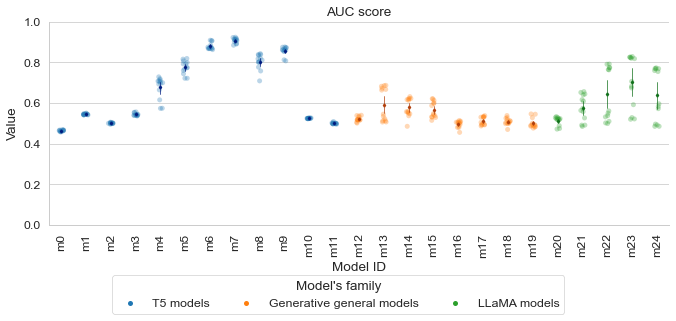

In [339]:
titles = ['AUC score']

g = sns.catplot(df_results_long.drop_duplicates(subset=['model', 'template', 'question'], keep='first'), 
    x='modelID', hue='model_family', y='value', col='metric', col_wrap=1, dodge=False, alpha=.3, 
    legend=True, zorder=1, kind='strip', sharex=False, margin_titles=False, height=4, aspect=1.7)#, ax=axes[i])
g.map_dataframe(sns.pointplot, x='modelID', y='value', hue='model_family', linestyle='none', 
    markers="d", markersize=2, palette='dark', errorbar='ci', err_kws={'linewidth': 0.7})
g.set(ylim=(0, 1), ylabel='Value', xlabel='Model ID')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=3, title="Model's family", frameon=True)
plt.savefig('../../results/plots/transcriptions_complete_general.png', bbox_inches='tight', dpi=600)

High performance

In [340]:
df_max = df_results.groupby('model')['auc'].agg(['max', 'std']).sort_values(by='max')
print(df_max)
print('\nPercentage below random: ', (df_max['max'] < 0.5).sum()/df_max.shape[0])

                          max       std
model                                  
t5-v1_1-base         0.468613  0.003572
t5-v1_1-xl           0.505270  0.002654
ClinicalT5-large     0.508644  0.003497
falcon-7b            0.513752  0.016326
ClinicalT5-base      0.526075  0.001171
llama-7b-hf          0.533035  0.020730
falcon-7b-instruct   0.537443  0.019710
mpt-7b               0.537905  0.017059
palmyra-base         0.539397  0.012013
mpt-7b-instruct      0.545862  0.023632
t5-v1_1-large        0.549719  0.002931
t5-v1_1-xxl          0.555783  0.006591
instruct-gpt-j-fp16  0.620999  0.039702
gpt-j-6b             0.631147  0.045253
llama-2-7b-hf        0.655936  0.064182
camel-5b-hf          0.686728  0.082121
flan-t5-base         0.728518  0.054005
medalpaca-7b         0.773105  0.127687
alpaca-7b-hf         0.791729  0.130770
flan-t5-large        0.819131  0.032678
llama-2-7b-chat-hf   0.828897  0.128534
T0_3B                0.842966  0.038064
T0pp                 0.875942  0.021932


Low performance

In [341]:
df_min = df_results.groupby('model')['auc'].min().sort_values()
print(df_min)
print('\nPercentage below random: ', (df_min < 0.5).sum()/df_min.shape[0])

model
falcon-7b              0.455054
t5-v1_1-base           0.457304
mpt-7b                 0.469336
llama-7b-hf            0.471132
mpt-7b-instruct        0.475965
llama-2-7b-hf          0.484312
medalpaca-7b           0.484720
gpt-j-6b               0.484938
falcon-7b-instruct     0.486610
t5-v1_1-xl             0.494756
ClinicalT5-large       0.495095
alpaca-7b-hf           0.498561
palmyra-base           0.500731
camel-5b-hf            0.505902
instruct-gpt-j-fp16    0.514259
llama-2-7b-chat-hf     0.519672
ClinicalT5-base        0.521964
t5-v1_1-xxl            0.535737
t5-v1_1-large          0.541013
flan-t5-base           0.573304
T0_3B                  0.708681
flan-t5-large          0.721561
T0pp                   0.807408
flan-t5-xl             0.862871
flan-t5-xxl            0.884360
Name: auc, dtype: float64

Percentage below random:  0.48


Analysis of differences

In [342]:
df_both = df_max.reset_index().merge(df_min.reset_index(), on='model')
df_both['diff'] = df_both['max'] - df_both['auc']
df_both.describe()

,max,std,auc,diff
count,25.000000,25.000000,25.000000,25.000000
mean,0.656377,0.036957,0.558210,0.098167
std,0.147564,0.040197,0.128843,0.091429
min,0.468613,0.001171,0.455054,0.004111
25%,0.537443,0.012013,0.484720,0.038666
50%,0.620999,0.020730,0.500731,0.068534
75%,0.791729,0.045253,0.541013,0.146209
max,0.923817,0.130770,0.884360,0.309224


<Axes: >

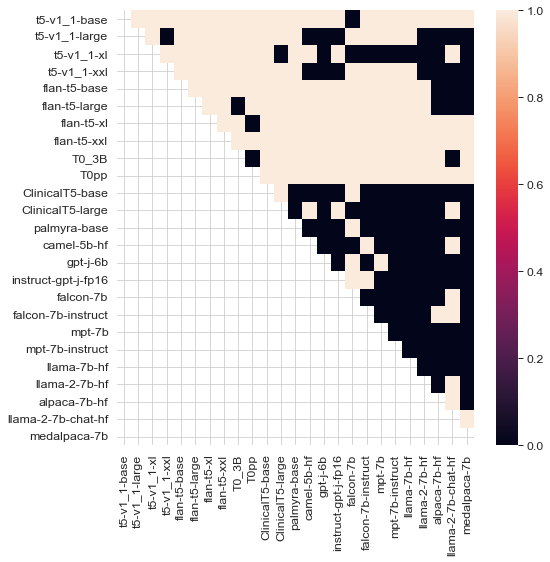

In [343]:
res = [(a, b) for idx, a in enumerate(models) for b in models[idx + 1:]]
resdf = pd.DataFrame(columns=models, index=models, dtype=int)

for x in res:
    temp = df_results.loc[df_results['model'] == x[0], ['model', 'template', 'question', 'auc']].merge(
        df_results.loc[df_results['model'] == x[1], ['model', 'template', 'question', 'auc']],
        on=['template', 'question'])
    resdf.loc[x[0], x[1]] = int(all((temp['auc_y'] - temp['auc_x']) > 0) | all((temp['auc_y'] - temp['auc_x']) < 0))

plt.figure(figsize=(8,8))
sns.heatmap(resdf)

In [344]:
aux = [('t5-v1_1-base', 'flan-t5-base'),
    ('t5-v1_1-large', 'flan-t5-large'),
    ('t5-v1_1-xl', 'flan-t5-xl'),
    ('t5-v1_1-xl', 'T0_3B'),
    ('t5-v1_1-xxl', 'flan-t5-xxl'),
    ('t5-v1_1-xxl', 'T0pp'),
    ('ClinicalT5-base', 'flan-t5-base'),
    ('ClinicalT5-large', 'flan-t5-large'),
    ('palmyra-base', 'camel-5b-hf'),
    ('gpt-j-6b', 'instruct-gpt-j-fp16'),
    ('falcon-7b', 'falcon-7b-instruct'),
    ('mpt-7b', 'mpt-7b-instruct'),
    ('llama-7b-hf', 'alpaca-7b-hf'),
    ('llama-7b-hf', 'llama-2-7b-chat-hf'),
    ('llama-7b-hf', 'medalpaca-7b'),
    ('llama-2-7b-hf', 'alpaca-7b-hf'),
    ('llama-2-7b-hf', 'llama-2-7b-chat-hf'),
    ('llama-2-7b-hf', 'medalpaca-7b')]

print('>> auc mean differences:')
temp = df_results.groupby('model')['auc'].mean().reset_index().merge(df_results.groupby('model')['auc']\
    .mean().reset_index().rename(columns={'model': 'model_x', 'auc': 'auc_x'}), how='cross')
temp['diff'] = temp['auc_x'] - temp['auc']
filter_ = np.zeros(temp.shape[0])
for i in aux:
    filter_[temp.loc[(temp['model'] == i[0]) & (temp['model_x'] == i[1]), ['model', 'diff']].index] = 1
print(temp[filter_.astype(bool)]['diff'].describe())

print('\n>> auc max differences:')
temp = df_results.groupby('model')['auc'].max().reset_index().merge(df_results.groupby('model')['auc']\
    .max().reset_index().rename(columns={'model': 'model_x', 'auc': 'auc_x'}), how='cross')
temp['diff'] = temp['auc_x'] - temp['auc']
filter_ = np.zeros(temp.shape[0])
for i in aux:
    filter_[temp.loc[(temp['model'] == i[0]) & (temp['model_x'] == i[1]), ['model', 'diff']].index] = 1
print(temp[filter_.astype(bool)]['diff'].describe())

>> auc mean differences:
count    18.000000
mean      0.166959
std       0.124551
min      -0.010950
25%       0.066503
50%       0.140915
75%       0.265537
max       0.378981
Name: diff, dtype: float64

>> auc max differences:
count    18.000000
mean      0.214514
std       0.123866
min      -0.010148
25%       0.138677
50%       0.249382
75%       0.306830
max       0.403740
Name: diff, dtype: float64


Analysis of prompt

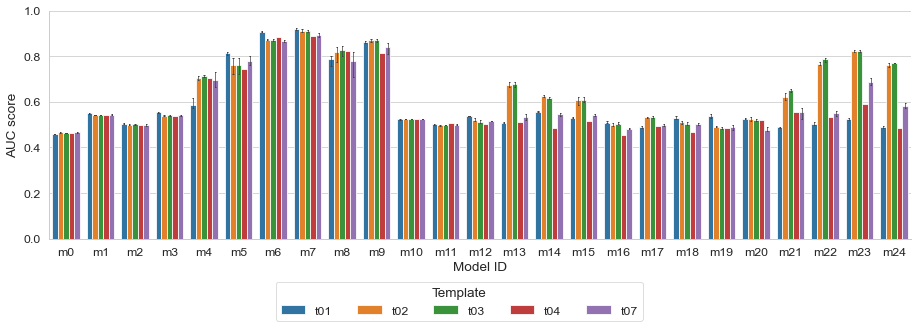

In [345]:
g = sns.catplot(data=df_results, x="modelID", y="auc", hue="template", capsize=.15, aspect=3, 
    err_kws={'linewidth': 0.7}, kind='bar', height=4)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.xlabel('Model ID')
plt.ylabel('AUC score')
plt.ylim([0,1])
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.15), ncol=7, title="Template", frameon=True)
plt.savefig('../../results/plots/transcriptions_complete_detail_template.png', bbox_inches='tight', dpi=600)

In [346]:
df_results[['template', 'model', 'auc']].groupby(['template', 'model'])['auc'].mean().reset_index()\
    .groupby('model')['auc'].std().describe()

count    25.000000
mean      0.038461
std       0.042935
min       0.000784
25%       0.013165
50%       0.022002
75%       0.052388
max       0.140302
Name: auc, dtype: float64

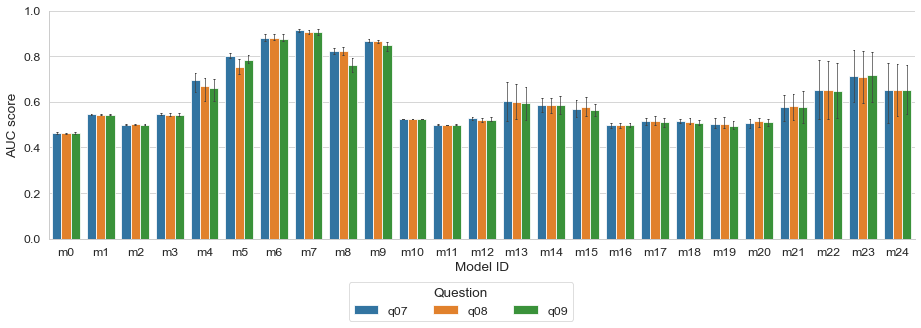

In [347]:
g = sns.catplot(data=df_results[df_results['question'] != ''], x="modelID", y="auc", hue="question", 
    capsize=.15, aspect=3, err_kws={'linewidth': 0.7}, kind='bar', height=4)
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.xlabel('Model ID')
plt.ylabel('AUC score')
plt.ylim([0,1])
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.15), ncol=3, title="Question", frameon=True)
plt.savefig('../../results/plots/transcriptions_complete_detail_question.png', bbox_inches='tight', dpi=600)

In [348]:
df_results[['model', 'auc', 'template']].groupby(['model', 'template'])['auc'].std().dropna()\
    .reset_index().describe()

,auc
count,100.000000
mean,0.007993
std,0.009741
min,0.000451
25%,0.002156
50%,0.004581
75%,0.008953
max,0.061040


#### B.2. Class analysis

In [349]:
df_class = create_perclass_df(df_results, ['model', 'template', 'question'], 
    individual_metrics, n_classes)
df_class.head()

,model,template,question,c_auc,class
375,t5-v1_1-base,t01,q07,0.482288,0
375,t5-v1_1-base,t01,q07,0.501188,1
375,t5-v1_1-base,t01,q07,0.487268,2
375,t5-v1_1-base,t01,q07,0.467362,3
375,t5-v1_1-base,t01,q07,0.364291,4


In [350]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'question', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,question,class,metric,value
0,t5-v1_1-base,t01,q07,0,c_auc,0.482288
1,t5-v1_1-base,t01,q07,1,c_auc,0.501188
2,t5-v1_1-base,t01,q07,2,c_auc,0.487268
3,t5-v1_1-base,t01,q07,3,c_auc,0.467362
4,t5-v1_1-base,t01,q07,4,c_auc,0.364291


In [351]:
df_class_long = pd.melt(df_class, id_vars=['model', 'template', 'question', 'class'], 
    var_name='metric')
df_class_long.head()

,model,template,question,class,metric,value
0,t5-v1_1-base,t01,q07,0,c_auc,0.482288
1,t5-v1_1-base,t01,q07,1,c_auc,0.501188
2,t5-v1_1-base,t01,q07,2,c_auc,0.487268
3,t5-v1_1-base,t01,q07,3,c_auc,0.467362
4,t5-v1_1-base,t01,q07,4,c_auc,0.364291


In [352]:
df_class_plot = df_class_long.groupby(['model', 'metric', 'class']).value.aggregate(['max', 'min']).reset_index()
df_class_plot['class'] = df_class_plot['class'].replace(dict(zip(
    df_class['class'].drop_duplicates().values.tolist(), data[dataset_name]['labels'])))
df_class_plot = df_class_plot.sort_values(by='class')

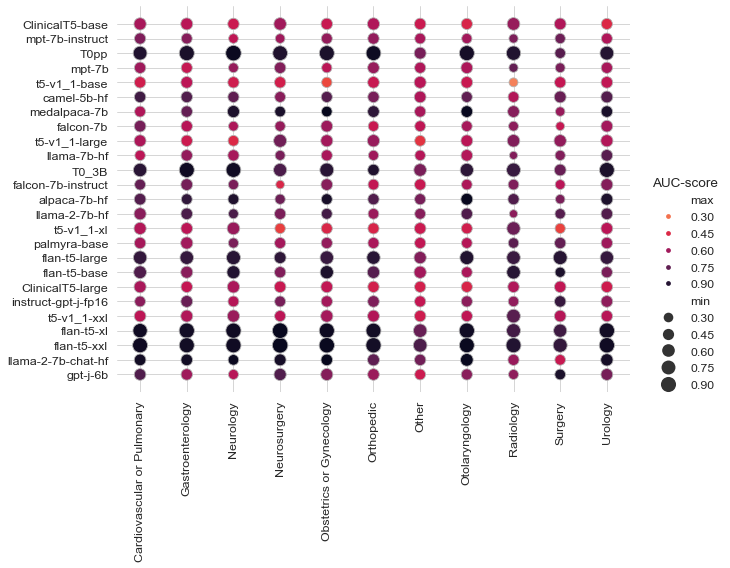

In [353]:
titles=['AUC-score']
for i, metric in enumerate(individual_metrics):
    g = sns.relplot(data=df_class_plot[df_class_plot['metric'] == metric], x='class', y='model', 
        hue='max', hue_norm=(0, 1), size='min', edgecolor='.7', sizes=(25, 250), size_norm=(0 , 1), 
        palette='rocket_r', height=8)
    g.set(xlabel="", ylabel="")
    g.despine(left=True, bottom=True)
    sns.move_legend(g, "center left", bbox_to_anchor=(1, 0.5), title=titles[i], frameon=False)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    plt.tight_layout()
    plt.savefig(f'../../results/plots/transcriptions_complete_class_{metric}.png', dpi=600)

## All approaches
**Task:** Classification

**Datasets:** Transcriptions and MS-CXR

### Set-up

In [354]:
results_encoder['task'] = 'CES'
results_encoder_mcqa['task'] = 'CES'
results_nli['task'] = 'NLI'
results_nli_mcqa['task'] = 'NLI'
results_complete['task'] = 'MCQA'

In [355]:
model_dict = {
    'bert-base-uncased': {'size': 110, 'type': 'Encoder'},
    'bert-large-uncased': {'size': 340, 'type': 'Encoder'},
    'BiomedNLP-PubMedBERT-base-uncased-abstract': {'size': 110, 'type': 'Encoder'},
    'BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': {'size': 110, 'type': 'Encoder'},
    'BiomedNLP-PubMedBERT-large-uncased-abstract': {'size': 340, 'type': 'Encoder'},
    'scibert_scivocab_uncased': {'size': 110, 'type': 'Encoder'},
    'SapBERT-from-PubMedBERT-fulltext': {'size': 110, 'type': 'Encoder'},
    'BioLORD-STAMB2-v1': {'size': 110, 'type': 'Encoder'},
    'BioLORD-STAMB2-v1-STS2': {'size': 110, 'type': 'Encoder'},
    'BioLORD-PMB': {'size': 110, 'type': 'Encoder'},
    'Bio_ClinicalBERT': {'size': 110, 'type': 'Encoder'},
    'nli-deberta-base': {'size': 100, 'type': 'NLI'},
    'roberta-large-mnli': {'size': 355, 'type': 'NLI'},
    'bart-large-mnli': {'size': 407, 'type': 'NLI'},
    't5-v1_1-base': {'size': 220, 'type': 'Encoder-decoder'},
    't5-v1_1-large': {'size': 770, 'type': 'Encoder-decoder'},
    't5-v1_1-xl': {'size': 3000, 'type': 'Encoder-decoder'},
    't5-v1_1-xxl': {'size': 11000, 'type': 'Encoder-decoder'},
    'flan-t5-base': {'size': 220, 'type': 'Encoder-decoder'},
    'flan-t5-large': {'size': 770, 'type': 'Encoder-decoder'},
    'flan-t5-xl': {'size': 3000, 'type': 'Encoder-decoder'},
    'flan-t5-xxl': {'size': 11000, 'type': 'Encoder-decoder'},
    'T0_3B': {'size': 3000, 'type': 'Encoder-decoder'},
    'T0pp': {'size': 11000, 'type': 'Encoder-decoder'},
    'ClinicalT5-base': {'size': 220, 'type': 'Encoder-decoder'},
    'ClinicalT5-large': {'size': 700, 'type': 'Encoder-decoder'},
    'palmyra-base': {'size': 5000, 'type': 'Decoder'},
    'camel-5b-hf': {'size': 5000, 'type': 'Decoder'},
    'gpt-j-6b': {'size': 6000, 'type': 'Decoder'},
    'instruct-gpt-j-fp16': {'size': 6000, 'type': 'Decoder'},
    'falcon-7b': {'size': 7000, 'type': 'Decoder'},
    'falcon-7b-instruct': {'size': 7000, 'type': 'Decoder'},
    'mpt-7b': {'size': 7000, 'type': 'Decoder'},
    'mpt-7b-instruct': {'size': 7000, 'type': 'Decoder'},
    'llama-7b-hf': {'size': 7000, 'type': 'Decoder'},
    'llama-2-7b-hf': {'size': 7000, 'type': 'Decoder'},
    'alpaca-7b-hf': {'size': 7000, 'type': 'Decoder'},
    'llama-2-7b-chat-hf': {'size': 7000, 'type': 'Decoder'},
    'medalpaca-7b': {'size': 7000, 'type': 'Decoder'}
}

model_detail = pd.DataFrame.from_dict(model_dict, orient='index').reset_index()
model_detail.rename(columns={'index': 'model'}, inplace=True)

### Graph 1: Performance vs. size

In [360]:
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log(size)'], data[metric])
    ax = plt.gca()
    ax.text(.8, .95, 'R^2={:.2f}'.format(r**2), transform=ax.transAxes, fontsize=10)
    ax.text(.75, .9, 'r={:.2f}, p-val={:.2g}'.format(r, p), transform=ax.transAxes, fontsize=10)

c:\Users\andre\anaconda3\envs\i2dl\lib\site-packages\seaborn\regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.



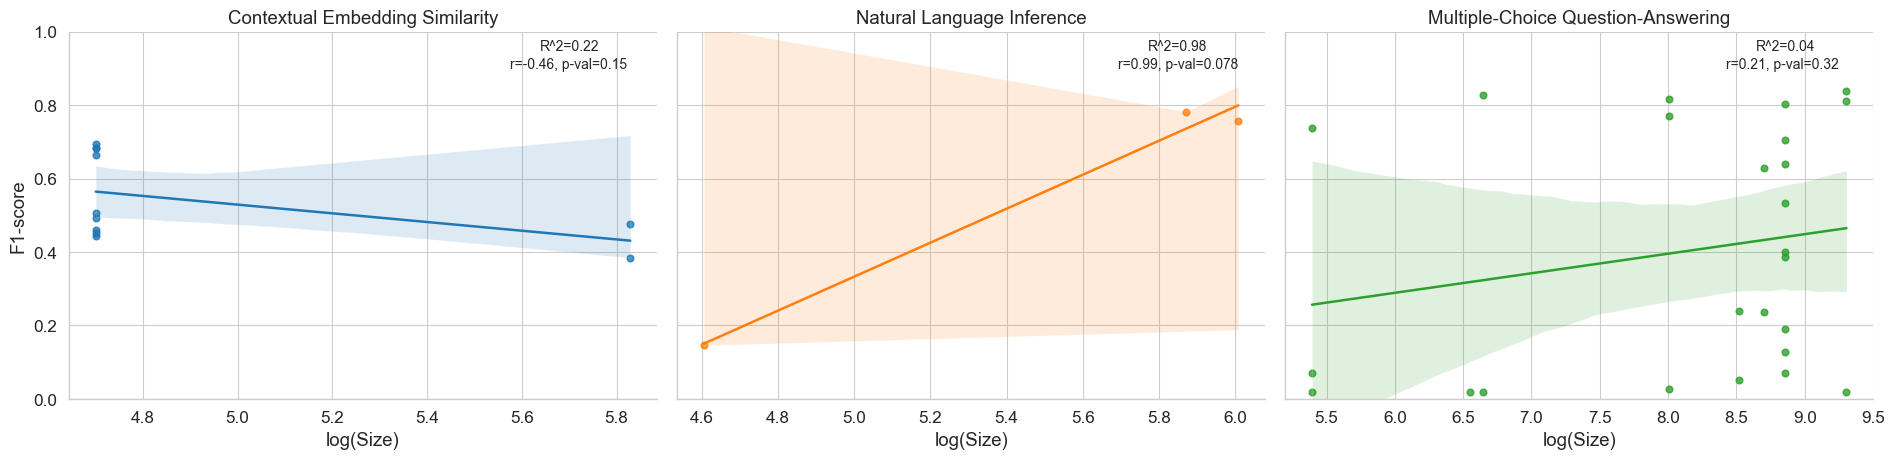

In [415]:
dataset = 'ms-cxr'
metric = 'f1'

df_aux = pd.concat([
    results_encoder.loc[results_encoder['data'] == dataset, ['model', metric, 'task', 'pool', 'template']],
    results_nli.loc[results_nli['data'] == dataset, ['model', metric, 'task']],
    results_complete.loc[results_complete['data'] == dataset, ['model', metric, 'task']]
])

df_aux = df_aux.groupby(['model', 'task'])[metric].max().reset_index()
df_aux = df_aux.merge(model_detail, on='model')
df_aux['log(size)'] = np.log(df_aux['size'])

df_aux['task'] = pd.Categorical(df_aux['task'], ['CES', 'NLI', 'MCQA'])
df_aux.sort_values(by='task', inplace=True)

titles = ['Contextual Embedding Similarity', 'Natural Language Inference', 'Multiple-Choice Question-Answering']
g = sns.lmplot(data=df_aux, x='log(size)', y=metric, col='task', hue='task', legend=True, sharex=False, 
    height=4.8, aspect= 1.33, palette=color_palette)
g.map_dataframe(annotate)
g.set(ylim=(0, 1), xlabel='log(Size)', ylabel='F1-score')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
plt.tight_layout()
g.savefig('../../results/plots/ms-cxr_graph1.png', dpi=600)

c:\Users\andre\anaconda3\envs\i2dl\lib\site-packages\seaborn\regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.



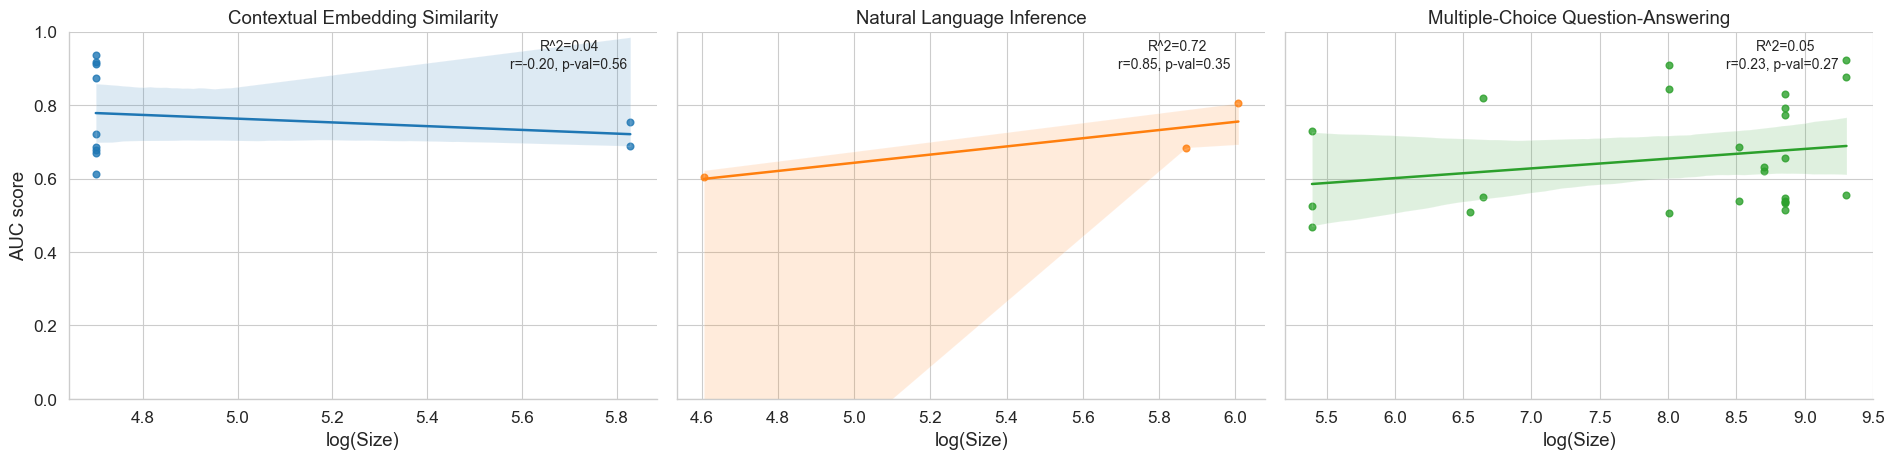

In [416]:
dataset = 'transcriptions'
metric = 'auc'

df_aux = pd.concat([
    results_encoder.loc[results_encoder['data'] == dataset, ['model', metric, 'task', 'pool', 'template']],
    results_nli.loc[results_nli['data'] == dataset, ['model', metric, 'task']],
    results_complete.loc[results_complete['data'] == dataset, ['model', metric, 'task']]
])

df_aux = df_aux.groupby(['model', 'task'])[metric].max().reset_index()
df_aux = df_aux.merge(model_detail, on='model')
df_aux['log(size)'] = np.log(df_aux['size'])

df_aux['task'] = pd.Categorical(df_aux['task'], ['CES', 'NLI', 'MCQA'])
df_aux.sort_values(by='task', inplace=True)

titles = ['Contextual Embedding Similarity', 'Natural Language Inference', 'Multiple-Choice Question-Answering']
g = sns.lmplot(data=df_aux, x='log(size)', y=metric, col='task', hue='task', legend=True, sharex=False, 
    height=4.8, aspect= 1.33, palette=color_palette)
g.map_dataframe(annotate)
g.set(ylim=(0, 1), xlabel='log(Size)', ylabel='AUC score')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
plt.tight_layout()
g.savefig('../../results/plots/transcriptions_graph1.png', dpi=600)

### Graph 3: Prompt impact

In [371]:
def label(x, color, label):
    titles = {'CES': 'Contextual\nembedding similarity', 'NLI': 'Natural language\ninference',
        'MCQA': 'Multiple-choice\nquestion-answering'}
    ax = plt.gca()
    ax.text(0, .5, titles[label], color=color, size=10,#fontweight="bold", 
        ha="left", va="center", transform=ax.transAxes)

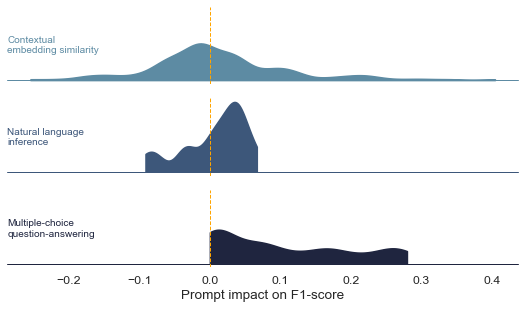

In [372]:
dataset = 'ms-cxr'
metric = 'f1'

# Encoder
re = results_encoder[results_encoder['data'] == dataset]\
    .groupby(['model', 'template', 'pool'])[metric].max().reset_index()
re = re.merge(re[re['template'] == ''], on=['model', 'pool'])
re = re[re['template_x'] != '']
re['diff'] = re[metric + '_x'] - re[metric + '_y']
re['task'] = 'CES'

# NLI
rn = results_nli[results_nli['data'] == dataset]\
    .groupby(['model', 'template'])[metric].max().reset_index()
rn = rn.merge(rn[rn['template'] == ''], on=['model'])
rn = rn[rn['template_x'] != '']
rn['diff'] = rn[metric + '_x'] - rn[metric + '_y']
rn['task'] = 'NLI'

# Complete
rc = results_complete.loc[results_complete['data'] == dataset, ['model', metric]]\
    .groupby(['model'])[metric].std().reset_index()
rc['task'] = 'MCQA'

# All
df_aux = pd.concat([
    re[['model', 'diff', 'task']].rename(columns={'diff': 'delta ' + metric}),
    rn[['model', 'diff', 'task']].rename(columns={'diff': 'delta ' + metric}),
    rc[['model', metric, 'task']].rename(columns={metric: 'delta ' + metric})
])


sns.set_style('white')
pal = sns.cubehelix_palette(len(df_aux['task'].unique()), rot=-.25, light=0.5)
g = sns.FacetGrid(df_aux, row='task', hue='task', aspect=5, height=1.5, palette=pal)
g.map(sns.kdeplot, 'delta ' + metric, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, cut=0)
g.map(plt.axhline, y=-0.05, lw=1, clip_on=False)
g.map(plt.axvline, x=0, ls='--', c='orange', linewidth=1)
g.map(label, 'delta ' + metric)
g.figure.subplots_adjust(hspace=-.15)
g.set_titles('')
g.set_xlabels('Prompt impact on ' + 'F1-score' if metric == 'f1' else 'AUC score')
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.tight_layout()
g.savefig('../../results/plots/ms-cxr_graph3.png', dpi=600)
sns.set_style('whitegrid')

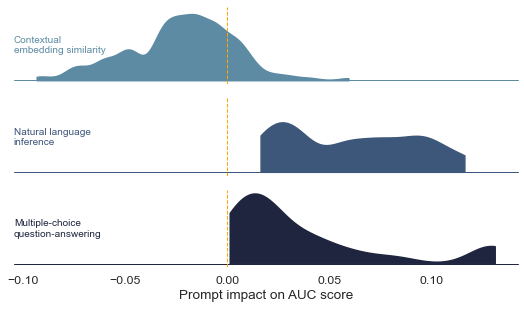

In [373]:
dataset = 'transcriptions'
metric = 'auc'

# Encoder
re = results_encoder[results_encoder['data'] == dataset]\
    .groupby(['model', 'template', 'pool'])[metric].max().reset_index()
re = re.merge(re[re['template'] == ''], on=['model', 'pool'])
re = re[re['template_x'] != '']
re['diff'] = re[metric + '_x'] - re[metric + '_y']
re['task'] = 'CES'

# NLI
rn = results_nli[results_nli['data'] == dataset]\
    .groupby(['model', 'template'])[metric].max().reset_index()
rn = rn.merge(rn[rn['template'] == ''], on=['model'])
rn = rn[rn['template_x'] != '']
rn['diff'] = rn[metric + '_x'] - rn[metric + '_y']
rn['task'] = 'NLI'

# Complete
rc = results_complete.loc[results_complete['data'] == dataset, ['model', metric]]\
    .groupby(['model'])[metric].std().reset_index()
rc['task'] = 'MCQA'

# All
df_aux = pd.concat([
    re[['model', 'diff', 'task']].rename(columns={'diff': 'delta ' + metric}),
    rn[['model', 'diff', 'task']].rename(columns={'diff': 'delta ' + metric}),
    rc[['model', metric, 'task']].rename(columns={metric: 'delta ' + metric})
])

sns.set_style('white')
pal = sns.cubehelix_palette(len(df_aux['task'].unique()), rot=-.25, light=0.5)
g = sns.FacetGrid(df_aux, row='task', hue='task', aspect=5, height=1.5, palette=pal)
g.map(sns.kdeplot, 'delta ' + metric, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, cut=0)
g.map(plt.axhline, y=-0.05, lw=1, clip_on=False)
g.map(plt.axvline, x=0, ls='--', c='orange', linewidth=1)
g.map(label, 'delta ' + metric)
g.figure.subplots_adjust(hspace=-.15)
g.set_titles('')
g.set_xlabels('Prompt impact on ' + ('F1-score' if metric == 'f1' else 'AUC score'))
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.tight_layout()
g.savefig('../../results/plots/transcriptions_graph3.png', dpi=600)
sns.set_style('whitegrid')

### Graph 4: Highest-performing

C:\Users\andre\AppData\Local\Temp\ipykernel_3564\1219199494.py:44: UserWarning:

FixedFormatter should only be used together with FixedLocator



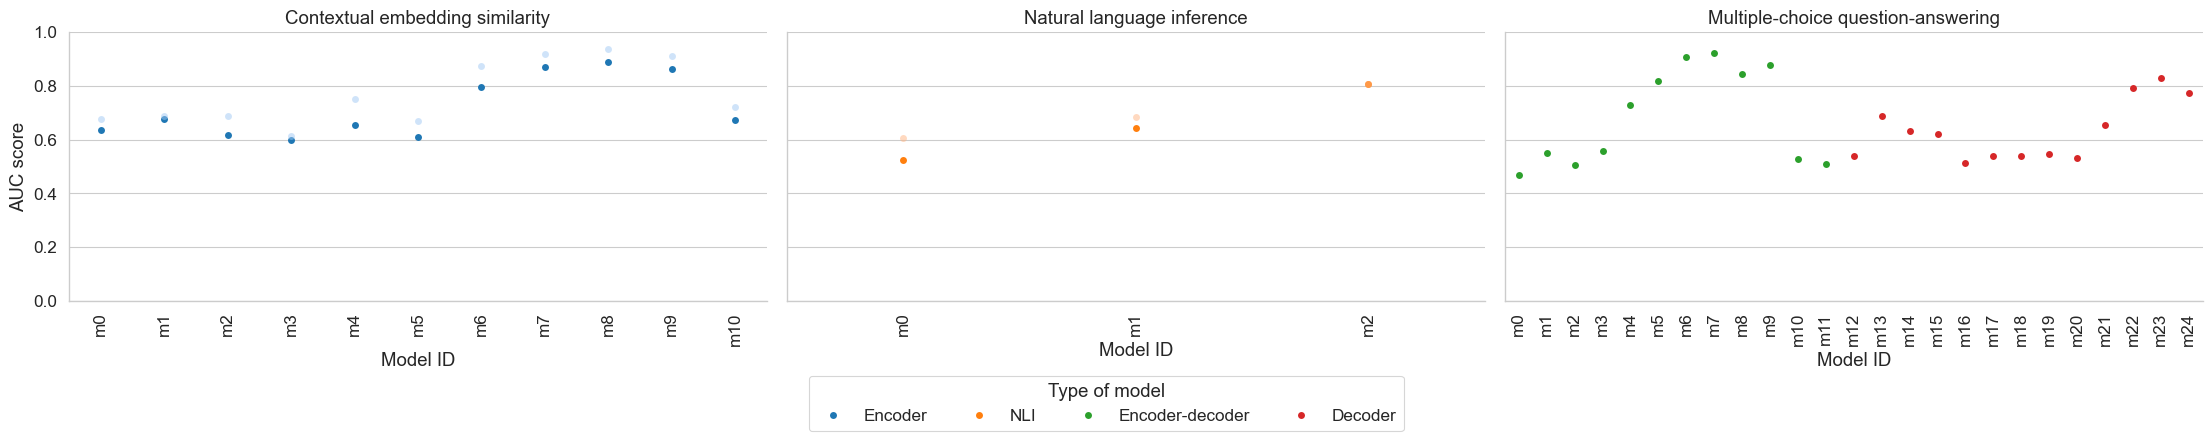

In [417]:
dataset = 'transcriptions'
metric = 'auc'

results_encoder['task'] = 'CES.f'
results_encoder_mcqa['task'] = 'CES'
results_nli['task'] = 'NLI.f'
results_nli_mcqa['task'] = 'NLI'
results_complete['task'] = 'MCQA'

df_aux = pd.concat([
    results_encoder.loc[results_encoder['data'] == dataset, ['model', 'modelID', metric, 'task', 'pool', 'template']],
    results_encoder_mcqa.loc[results_encoder_mcqa['data'] == dataset, ['model', 'modelID', metric, 'task', 'pool', 'template']],
    results_nli.loc[results_nli['data'] == dataset, ['model', 'modelID', metric, 'task']],
    results_nli_mcqa.loc[results_nli_mcqa['data'] == dataset, ['model', 'modelID', metric, 'task']],
    results_complete.loc[results_complete['data'] == dataset, ['model', 'modelID', metric, 'task']]
])

df_aux = df_aux.groupby(['model', 'modelID', 'task'])[metric].max().reset_index()
df_aux = df_aux.merge(model_detail, on='model')
df_aux['log(size)'] = np.log(df_aux['size'])

col_aux = pd.DataFrame(np.concatenate([results_encoder.model.unique(), results_nli.model.unique(), 
    results_complete.model.unique()]))
col_aux.columns = ['model']
df_aux = col_aux.merge(df_aux)

filter_ = df_aux['task'].str.contains('.f')
df_extra = df_aux.loc[filter_, ['model', metric]]
df_aux = df_aux[~filter_]
df_aux = df_aux.merge(df_extra, on='model', how='left', suffixes=('', '.f'))

titles = ['Contextual embedding similarity', 'Natural language inference', 
    'Multiple-choice question-answering']
g = sns.catplot(df_aux, x='modelID', y=metric, hue='type', col='task', col_wrap=3, 
    legend=True, kind='strip', sharex=False, margin_titles=False, height=4, aspect= 1.7,
    palette={'Encoder': color_palette[0], 'NLI': color_palette[1], 'Encoder-decoder': color_palette[2],
        'Decoder':color_palette[3]})
g.map_dataframe(sns.stripplot, x='modelID', y=metric + '.f', hue='type', alpha=.5,
    palette={'Encoder': pastel_palette[0], 'NLI': pastel_palette[1], 
        'Encoder-decoder': pastel_palette[2], 'Decoder':pastel_palette[3]})
g.set(ylim=(0, 1), ylabel='AUC score', xlabel='Model ID')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for lh in g._legend.legend_handles:
    lh.set_alpha(1)
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Type of model', frameon=True)
plt.savefig('../../results/plots/transcriptions_graph4.png', bbox_inches='tight', dpi=600)

C:\Users\andre\AppData\Local\Temp\ipykernel_3564\3371675587.py:32: UserWarning:

FixedFormatter should only be used together with FixedLocator



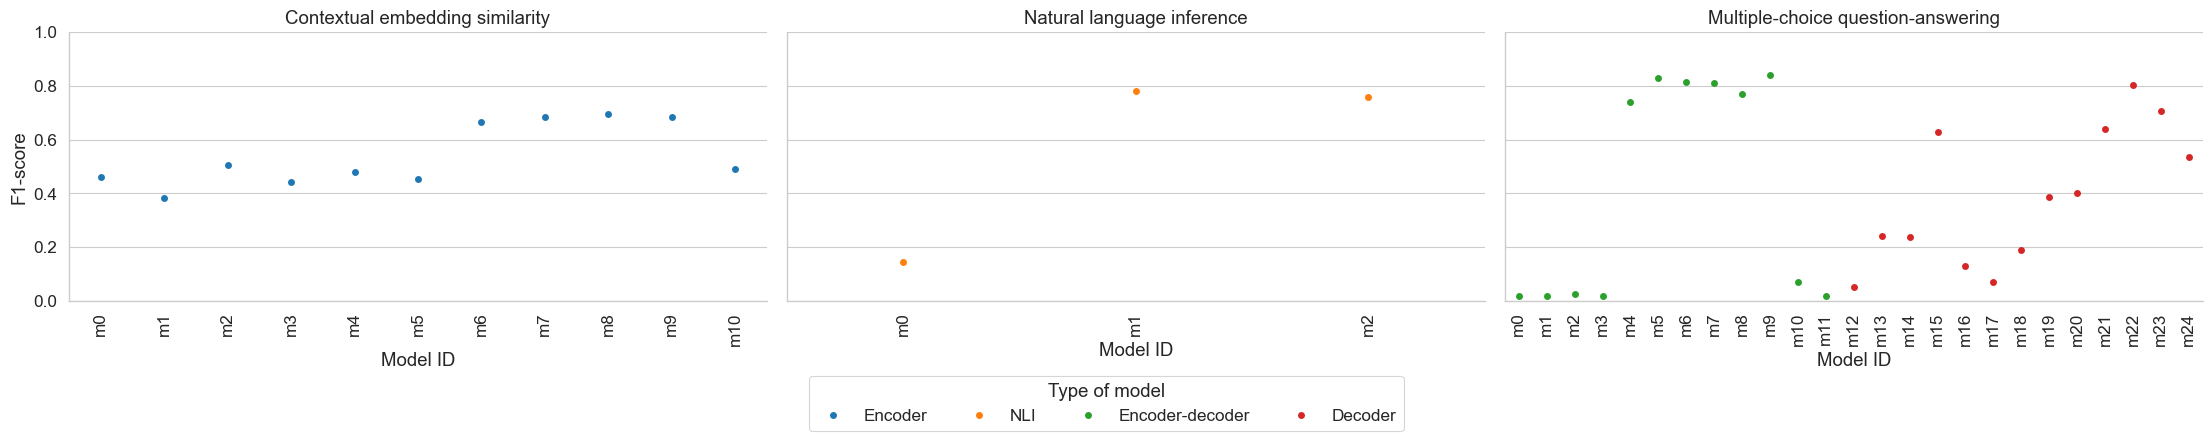

In [418]:
dataset = 'ms-cxr'
metric = 'f1'

results_encoder['task'] = 'CES'
results_nli['task'] = 'NLI'
results_complete['task'] = 'MCQA'

df_aux = pd.concat([
    results_encoder.loc[results_encoder['data'] == dataset, ['model', 'modelID', metric, 'task', 'pool', 'template']],
    results_nli.loc[results_nli['data'] == dataset, ['model', 'modelID', metric, 'task']],
    results_complete.loc[results_complete['data'] == dataset, ['model', 'modelID', metric, 'task']]
])

df_aux = df_aux.groupby(['model', 'modelID', 'task'])[metric].max().reset_index()
df_aux = df_aux.merge(model_detail, on='model')
df_aux['log(size)'] = np.log(df_aux['size'])

col_aux = pd.DataFrame(np.concatenate([results_encoder.model.unique(), results_nli.model.unique(), 
    results_complete.model.unique()]))
col_aux.columns = ['model']
df_aux = col_aux.merge(df_aux)

titles = ['Contextual embedding similarity', 'Natural language inference', 
    'Multiple-choice question-answering']
g = sns.catplot(df_aux, x='modelID', y=metric, hue='type', col='task', col_wrap=3, 
    legend=True, kind='strip', sharex=False, margin_titles=False, height=4, aspect= 1.7,
    palette={'Encoder': color_palette[0], 'NLI': color_palette[1], 'Encoder-decoder': color_palette[2],
        'Decoder':color_palette[3]})
g.set(ylim=(0, 1), ylabel='F1-score', xlabel='Model ID')
for ax, title in zip(g.axes.flatten(), titles):
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for lh in g._legend.legend_handles:
    lh.set_alpha(1)
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=4, title='Type of model', frameon=True)
plt.tight_layout()
plt.savefig('../../results/plots/ms-cxr_graph4.png', bbox_inches='tight', dpi=600)